# Setup

In [1]:
from IPython.core.display import display 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import pickle
%cd /nlpgpu/data/artemisp/visual_unit_testing
import sys
import scipy.stats as st
from tqdm import tqdm

from statsmodels import robust
from accuracy_fns import GQA_accuracy, general_accuracy
from utils import extract_python_code
from postproc_utils import general_postprocessing, gqa_postproc
# sys.path.append('/export/einstein-vision-hs/viper')
# from image_patch import ImagePatch
import random
import json
random.seed(42)
# pd.set_option("display.max_rows", None) 
# sys.path.append('/export/einstein-vision-hs/viper')
# from image_patch import ImagePatch
import random
random.seed(42)


/tmp/ipykernel_549/2279561674.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/mnt/nlpgpu-io1/data/artemisp/visual_unit_testing


In [2]:
import os
os.environ['PYTHONPATH'] = '/nlpgpu/data/artemisp/visual_unit_testing:$CONDA_PREFIX/'
os.environ['HF_HOME'] = '/nlpgpu/data/artemisp/.cache/huggingface'
os.environ['TORCH_HOME'] = '/nlpgpu/data/artemisp/visual_unit_testing/.cache/'
os.environ['HF_ACCESS_TOKEN'] = '<HF_TOKEN>'
os.environ['HF_TOKEN'] = '<HF_TOKEN>'
os.environ['CUDA_HOME'] = os.environ['CONDA_PREFIX']
os.environ['CONFIG_NAMES'] = 'demo_config'
os.environ["GQA_IMAGE_PATH"] = "/nlp/data/vision_datasets/GQA"
os.environ["WINOGROUND_IMAGE_PATH"] = "/nlp/data/vision_datasets/winoground/data/images"
os.environ["COCO_VAL2017"] = "/nlp/data/vision_datasets/winoground/data/images"
plot_path = '/nlpgpu/data/artemisp/visual_unit_testing/plots/'

In [3]:
from collections import defaultdict

def max_count_accuracy(outputs, answer, fixed_code=False, accuracy_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    if isinstance(outputs, dict):
        outputs = outputs.values()
    with_errors = [o for o in outputs]
    no_errors = [o for o in outputs if o['error'] is None]
    answers = [o['output'] for o in no_errors]
    if len(answers) == 0:
        if len(with_errors)>0 and fixed_code:
            return accuracy_fn([with_errors[0]['output']], [answer])
        else:
            return 0
    counts = {a:answers.count(a) for a in set(answers)}
    # resolve ties by random selection
    # check for ties
    max_count = max(counts.values())
    max_count_answers = [a for a in counts if counts[a] == max_count]
    if len(max_count_answers) > 1:
       return 0
    else:
        max_count_answer = max_count_answers[0]
    return accuracy_fn([max_count_answer], [answer])

def unit_test_score_penalyze_error_raw(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc, aggregator=np.mean):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        curr_scores = []
        for t in range(len(curr_res)):
            curr_scores.append(sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results']))
        scores[code_index] = aggregator(np.array(curr_scores))
    max_index = max(scores, key=scores.get)
    return scores[max_index]

from copy import copy
def unit_test_score_penalyze_error(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc, aggregator=np.mean):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        # print(unit_test_results[0][code_index]['results'])
        org_ut = copy(selected_unit_tests)
        if isinstance(selected_unit_tests, dict):
            selected_unit_tests = selected_unit_tests[0][code_index]
                        
        curr_scores = []
        for t in range(len(curr_res)):
            try:
                curr_scores.append(sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results']))

                # scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
            except:
                print('Error in {}'.format(code_index))
                curr_scores.append(sum([(ut['acc'] if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']]))
                # scores[code_index] += sum([(ut['acc'] if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
        scores[code_index] = aggregator(np.array(curr_scores))
    max_index = max(scores, key=scores.get)
    return max_index

def unit_test_score_penalyze_error_all_max(selected_unit_tests, unit_test_results, compilation_error_penalty=0.1, runtime_error_penalty=0.1, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    for code_index in range(len(unit_test_results[0])):
        curr_res = unit_test_results[0][code_index]['results']
        for t in range(len(curr_res)):
            scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]])  if ut['error'] is not None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
    max_indices = [k for k in scores if scores[k] == max(scores.values())]
    return max_indices



def get_folder_upper_bound_accuracy(folder, compute='any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for i in [1,2,3, 4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                    gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                    if 'code_outputs' not in gqa_data[0]:
                        print('No code_outputs found in {}'.format(folder.format(i,s)))
                        continue
                    key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
                    if compute == 'max_count':
                        id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0], d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
                    elif compute == 'max_count_with_fixed_code':
                        id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0], d['answer'],accuracy_fn=acc_fn, postproc_fn=postproc_fn,fixed_code=True) for d in gqa_data}
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [acc_fn([m['output']],[d['answer']]) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'any':
                        id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values()]) for d in gqa_data}
                    elif compute == 'fixed_code':
                        id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) for m in d['code_outputs'][0].values()]) for d in gqa_data}

                    
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                        # keys = [k[:-2] for k in id2acc.keys()]
                        # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                        # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                        # id2acc = id2acc_
                    
                    correct = sum(id2acc.values())
                    total = len(gqa_data)
                    data['num_programs'].append(i)
                    data['acc'].append((correct/total)*100.)
                    data['run'].append(s)
    return pd.DataFrame(data)

def get_base_accuracy(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(i,s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([m['output']],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn,postproc_fn=postproc_fn, fixed_code=True) for d in gqa_data}
            # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
            #     keys = [k[:-1] for k in id2acc.keys()]
            #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                # keys = [k[:-2] for k in id2acc.keys()]
                # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                # id2acc = id2acc_
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data)

def get_base_scores(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    folder2id2acc = {}
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(i,s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], postproc_fn=postproc_fn, accuracy_fn=acc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([postproc_fn(m['output'])],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([postproc_fn(m['output'])],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc = {d[key]: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn,postproc_fn=postproc_fn, fixed_code=True) for d in gqa_data}
            # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
            #     keys = [k[:-1] for k in id2acc.keys()]
            #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                # keys = [k[:-2] for k in id2acc.keys()]
                # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                # id2acc = id2acc_
            folder2id2acc[folder.format(s)] = id2acc
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data), folder2id2acc


def get_fixed_accuracy(folder, compute = 'any'):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for s in [1,2,3]:#range(1,1):
        if not os.path.exists(folder.format(s)) or not os.path.exists(os.path.join(folder.format(s), 'data.p')):
            print('Folder {} does not exist'.format(folder.format(s)))
            continue
        else:
            gqa_data = pickle.load(open(os.path.join(folder.format(s), 'data.p'), 'rb'))
            if 'code_outputs' not in gqa_data[0]:
                print('No code_outputs found in {}'.format(folder.format(s)))
                continue
            key = 'sample_id' if 'sample_id' in gqa_data[0] else 'id'
            if compute == 'max_count':
                id2acc = {d['id']: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], accuracy_fn=acc_fn, postproc_fn=postproc_fn) for d in gqa_data}
            elif compute == 'first_non_error':
                id2acc = {d[key]: [int(acc_fn([postproc_fn(m['output'])],[d['answer']])) for m in d['code_outputs'][0].values() if m['error'] is None][0] if len([m for m in d['code_outputs'][0].values() if m['error'] is None]) else 0 for d in gqa_data}
            elif compute == 'any':
                id2acc = {d[key]: any([acc_fn([postproc_fn(m['output'])],[d['answer']]) if m['error'] is None else 0 for m in d['code_outputs'][0].values() if m['error'] is None]) for d in gqa_data}
            elif compute == 'fixed_code':
                id2acc =  {d['id']: max_count_accuracy(d['code_outputs'][0].values(), d['answer'], postproc_fn=postproc_fn, accuracy_fn=acc_fn, fixed_code=True) for d in gqa_data}
            # if 'winoground' in folder.lower():
            #         keys = [k[:-1] for k in id2acc.keys()]
            #         id2acc = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    # keys = [k[:-2] for k in id2acc.keys()]
                    # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    # id2acc = id2acc_
            correct = sum(id2acc.values())#sum([id2acc[d['sample_id']] for d in gqa_data])
            total = len(gqa_data)
            data['num_programs'].append(1)
            data['acc'].append((correct/total)*100.)
            data['run'].append(s)
    return pd.DataFrame(data)

def get_folder_accuracy(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1,filter=None, aggregator=np.mean):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    for i in [2,3,4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                if filter is not None:
                    if isinstance(filter, list):
                        gqa_data = [d for d in gqa_data if any([f in d['question'] for f in filter])]
                    else:
                        gqa_data = [d for d in gqa_data if any(v in d[k] for k,v in filter.items())]
                # if 'final_accuracy' not in gqa_data[0]:
                #     print('No final_accuracy found in {}'.format(folder.format(i,s)))
                #     continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                if True:
                    if compute == 'penalyze_error':
                        if 'code_outputs' not in gqa_data[0]:
                            print('No code_outputs found in {}'.format(folder.format(i,s)))
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                
                                try:
                                    curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                except:
                                    print(d['max_accuracy_code'])
                                    print(curr_codes)
                                if max_code_index not in curr_max_code_index:
                                    print('Code index mismatch')
                                    print(max_code_index, curr_max_code_index)
                                    print(d['generated_code'][d['max_accuracy_iter']])
                                    print(d['max_accuracy_code'])
                                else:
                                    if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                    else: 
                                        id2acc[d[key]] = 0
                        
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn, aggregator=aggregator)
                                if d['code_outputs'][0][max_code_index]['error'] is None:
                                    id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                else:
                                    id2acc[d[key]] = 0                                                                                              
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['max_accuracy_output'] if m['error'] is None][0] if len([m for m in d['max_accuracy_output'] if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'max_count':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn,postproc_f=postproc_fn, aggregator=aggregator) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], acc_fn=acc_fn, postproc_fn=postproc_fn) for j,d in enumerate(gqa_data)}
                    elif compute == 'max_count_with_fixed_code':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn, aggregator=aggregator) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], fixed_code=True, acc_fn=acc_fn,postproc_fn=postproc_fn) for j,d in enumerate(gqa_data)}
                    elif compute == 'fixed_code':
                        if 'code_outputs' not in gqa_data[0]:
                            if 'code_outputs' not in gqa_data[0]:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn, aggregator=aggregator)
                                    curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                    
                                    try:
                                        curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                    except:
                                        print(d['max_accuracy_code'])
                                        print(curr_codes)
                                    if max_code_index not in curr_max_code_index:
                                        print('Code index mismatch')
                                        print(max_code_index, curr_max_code_index)
                                        print(d['generated_code'][d['max_accuracy_iter']])
                                        print(d['max_accuracy_code'])
                                    else:
                                        # if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                        # else: 
                                        #     id2acc[d[key]] = 0
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn, aggregator=aggregator)
                                if d['code_outputs'][0][max_code_index]['error'] is None:
                                    id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                else:
                                    id2acc[d[key]] = 0   
                                  
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                        
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    #     # keys = [k[:-2] for k in id2acc.keys()]
                    #     # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    #     # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    #     id2acc = id2acc_
                # except:
                #     print('Error in {}'.format(folder.format(i,s)))
                #     continue
                correct = sum(id2acc.values())
                total = len(gqa_data)
                data['num_programs'].append(i)
                data['acc'].append((correct/total)*100.)
                data['run'].append(s)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data)

def get_folder_scores(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1):
    data ={'num_programs': [], 'acc': [], 'run': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    postproc_fn = gqa_postproc if 'gqa' in folder.lower() else general_postprocessing
    folder2id2acc = {}
    for i in [2,3,4,5]:
        for s in [1,2,3]: #range(1,1):
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                # if 'final_accuracy' not in gqa_data[0]:
                #     print('No final_accuracy found in {}'.format(folder.format(i,s)))
                #     continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                if True:
                    if compute == 'penalyze_error':
                        if 'code_outputs' not in gqa_data[0]:
                            print('No code_outputs found in {}'.format(folder.format(i,s)))
                            id2acc = {}
                            for d in gqa_data:
                                max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn,postproc_fn=postproc_fn)
                                curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                
                                try:
                                    curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                except:
                                    print(d['max_accuracy_code'])
                                    print(curr_codes)
                                if max_code_index not in curr_max_code_index:
                                    print('Code index mismatch')
                                    print(max_code_index, curr_max_code_index)
                                    print(d['generated_code'][d['max_accuracy_iter']])
                                    print(d['max_accuracy_code'])
                                else:
                                    if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                    else: 
                                        id2acc[d[key]] = 0
                        
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            # for 
                            # id2acc = {d[key]: d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['acc'] if d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['error'] is None else 0  for d in gqa_data}
                                                                                              
                    elif compute == 'first_non_error':
                        id2acc = {d[key]: [int(acc_fn([m['output']],[d['answer']])) for m in d['max_accuracy_output'] if m['error'] is None][0] if len([m for m in d['max_accuracy_output'] if m['error'] is None]) else 0 for d in gqa_data}
                    elif compute == 'max_count':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer']) for j,d in enumerate(gqa_data)}
                    elif compute == 'max_count_with_fixed_code':
                        max_indices = [unit_test_score_penalyze_error_all_max(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn) for d in gqa_data]
                        max_outputs = [[d['code_outputs'][0][i] for i in max_indices[j]] for j,d in enumerate(gqa_data)]
                        id2acc = {d[key]: max_count_accuracy(max_outputs[j], d['answer'], fixed_code=True) for j,d in enumerate(gqa_data)}
                    elif compute == 'random':
                        id2acc = {d[key]:d['final_accuracy'] if d['max_accuracy_output'][0]['error'] is None else 0 for d in gqa_data}
                    elif compute == 'fixed_code':
                        if 'code_outputs' not in gqa_data[0]:
                            if 'code_outputs' not in gqa_data[0]:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                    curr_codes = [extract_python_code(gc) for gc in d['generated_code'][0]]
                                    
                                    try:
                                        curr_max_code_index = [[extract_python_code(gc) for gc in d['generated_code'][0]].index(c) for c in d['max_accuracy_code']]
                                    except:
                                        print(d['max_accuracy_code'])
                                        print(curr_codes)
                                    if max_code_index not in curr_max_code_index:
                                        print('Code index mismatch')
                                        print(max_code_index, curr_max_code_index)
                                        print(d['generated_code'][d['max_accuracy_iter']])
                                        print(d['max_accuracy_code'])
                                    else:
                                        # if d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['error'] is None:
                                        id2acc[d[key]] = acc_fn([d['max_accuracy_output'][curr_max_code_index.index(max_code_index)]['output']], [d['answer']])
                                        # else: 
                                        #     id2acc[d[key]] = 0
                            else:
                                id2acc = {}
                                for d in gqa_data:
                                    if 'unit_test_results' not in d:
                                        print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                        continue
                                    max_code_index = unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn, postproc_fn=postproc_fn)
                                    if d['code_outputs'][0][max_code_index]['error'] is None:
                                        id2acc[d[key]] = d['code_outputs'][0][max_code_index]['acc']
                                    else:
                                        id2acc[d[key]] = 0
                        else:
                            if 'unit_test_results' not in gqa_data[0]:
                                print('No unit_test_results found in {}'.format(folder.format(i,s)))
                                continue
                            # id2acc = {d[key]: d['code_outputs'][0][unit_test_score_penalyze_error(d['selected_unit_tests'], d['unit_test_results'],compilation_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, acc_fn=acc_fn)]['acc'] for d in gqa_data}
                    folder2id2acc[folder.format(i,s)] = id2acc
                    # if 'winoground' in folder.lower() or 'sugarcrepe' in folder.lower():
                    #     from sklearn.metrics import f1_score
                    #     pred = [id2acc[d[key]] for d in gqa_data]
                    #     gt = [d['answer'] for d in gqa_data]
                    #     print(f1_score(gt, pred))
                        
                    #     keys = [k[:-1] for k in id2acc.keys()]
                    #     id2acc_ = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                    #     # keys = [k[:-2] for k in id2acc.keys()]
                    #     # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                    #     # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                    #     id2acc = id2acc_
                # except:
                #     print('Error in {}'.format(folder.format(i,s)))
                #     continue
                correct = sum(id2acc.values())
                total = len(gqa_data)
                data['num_programs'].append(i)
                data['acc'].append((correct/total)*100.)
                data['run'].append(s)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data), folder2id2acc

def get_marp_selection_baseline(folder, results_folder, compute='no_error'):
    output = {'num_programs': [], 'acc': [], 'run': []}

    for s in [1,2,3]:
        for p in [2,3,4,5]:
            
            if not os.path.exists(results_folder.format(p,s)):
                print('Folder {} does not exist'.format(results_folder.format(p,s)))
                continue
            if not os.path.exists(folder.format(p,s)) or not os.path.exists(os.path.join(folder.format(p,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(p,s)))
                continue
            index2code = pickle.load(open(results_folder.format(p,s), 'rb'))   
            data = pickle.load(open(os.path.join(folder.format(p,s), 'data.p'), 'rb'))
            key = 'sample_id' if 'sample_id' in data[0] else 'id'
            print(index2code)
            try:
                if compute == 'no_error':
                    id2acc = {d[key]:d['code_outputs'][0][index2code[idx]]['acc'] if (index2code[idx] is not None and d['code_outputs'][0][index2code[idx]]['error'] is None) else 0 for idx, d in enumerate(data)} 

                else:
                    id2acc = {d[key]:d['code_outputs'][0][index2code[idx]]['acc'] if index2code[idx] is not None else 0 for idx, d in enumerate(data)} 
            except:
                print('Error in {}'.format(folder.format(p,s)))
                continue
            correct = sum(id2acc.values())
            total = len(data)
            output['num_programs'].append(p)
            output['acc'].append((correct/total)*100.)
            output['run'].append(s)
    return pd.DataFrame(output)

In [4]:
def acc_relative_to_base(row):
    base_acc = base_data[base_data['run'] == row['run']]['acc'].values[0]
    return 100* (row['acc'] - base_acc)/base_acc
def mad(data):
    return np.median(np.abs(data - np.median(data)))

# Subset Ablations

## Base

### GQA

In [10]:
### PLOT BASE ACCURACY GQA ## 
base_accuracy_gqa = get_base_accuracy('results/GQA/eval/sample_per_type_3/base_execution_corr/1program/run{}')
upper_bound_accuracy_gqa = get_folder_upper_bound_accuracy('results/GQA/eval/sample_per_type_3/base_execution_corr/{}program/run{}', compute='any')
first_non_error_accuracy_gqa = get_folder_upper_bound_accuracy('results/GQA/eval/sample_per_type_3/base_execution_corr/{}program/run{}', compute='first_non_error')
max_count_accuracy_gqa = get_folder_upper_bound_accuracy('results/GQA/eval/sample_per_type_3/base_execution_corr/{}program/run{}', compute='max_count')

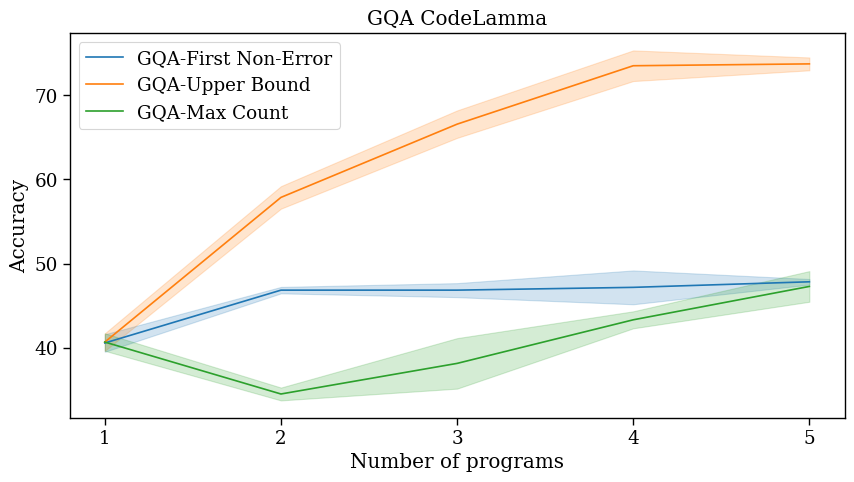

In [11]:
plt.figure(figsize=(10,5))
# fontsize
sns.set_context("paper", font_scale=1.5)
g=sns.lineplot(pd.concat((base_accuracy_gqa,first_non_error_accuracy_gqa)), x='num_programs', y='acc', errorbar='sd', estimator=np.median, label='GQA-First Non-Error')
g=sns.lineplot(pd.concat((base_accuracy_gqa,upper_bound_accuracy_gqa)), x='num_programs', y='acc', errorbar='sd', estimator=np.mean, label='GQA-Upper Bound')
g=sns.lineplot(pd.concat((base_accuracy_gqa,max_count_accuracy_gqa)), x='num_programs', y='acc', errorbar='sd', estimator=np.mean, label='GQA-Max Count')
g.set_xticks([1,2,3,4,5])
g.set_xlabel('Number of programs')
g.set_ylabel('Accuracy')
g.set_title('GQA-Upper Bound')
plt.title('GQA CodeLamma')
plt.show()

### WinoGround

In [10]:
### PLOT BASE ACCURACY GQA ## 
base_accuracy_wg = get_base_accuracy('results/WinoGround/eval/sample_per_type_3/base_execution_high_temp/1program/run{}')
upper_bound_accuracy_wg = get_folder_upper_bound_accuracy('results/WinoGround/eval/sample_per_type_3/base_execution_high_temp/{}program/run{}', compute='any')
first_non_error_accuracy_wg = get_folder_upper_bound_accuracy('results/WinoGround/eval/sample_per_type_3/base_execution_high_temp/{}program/run{}', compute='first_non_error')
max_count_accuracy_wg = get_folder_upper_bound_accuracy('results/WinoGround/eval/sample_per_type_3/base_execution_high_temp/{}program/run{}', compute='max_count')

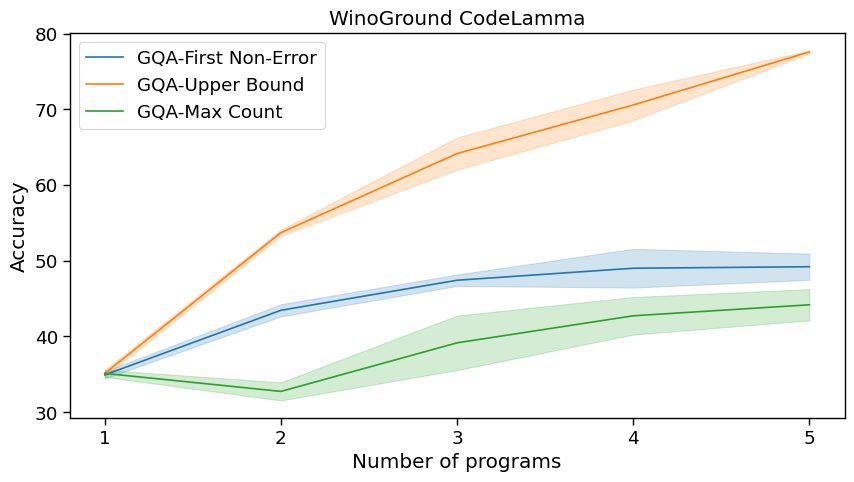

In [11]:
plt.figure(figsize=(10,5))
# fontsize
sns.set_context("paper", font_scale=1.5)
g=sns.lineplot(pd.concat((base_accuracy_wg,first_non_error_accuracy_wg)), x='num_programs', y='acc', errorbar='sd', estimator=np.median, label='GQA-First Non-Error')
g=sns.lineplot(pd.concat((base_accuracy_wg,upper_bound_accuracy_wg)), x='num_programs', y='acc', errorbar='sd', estimator=np.mean, label='GQA-Upper Bound')
g=sns.lineplot(pd.concat((base_accuracy_wg,max_count_accuracy_wg)), x='num_programs', y='acc', errorbar='sd', estimator=np.mean, label='GQA-Max Count')
g.set_xticks([1,2,3,4,5])
g.set_xlabel('Number of programs')
g.set_ylabel('Accuracy')
g.set_title('WinoGround-Upper Bound')
plt.title('WinoGround CodeLamma')
plt.show()

## Number of unit tests

### GQA

In [12]:
all_data = []
for ut in [1,3,5,7,9]:
    dt = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    dt['num_unit_test'] = ut
    all_data.append(dt)
gqa_num_ut = pd.concat(all_data)
gqa_num_ut['Dataset'] = 'GQA'

    

### WinoGround

In [13]:
all_data = []
for ut in [1,3,5,7,9]:
    dt = get_folder_accuracy(f'results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    dt['num_unit_test'] = ut
    all_data.append(dt)
wg_num_ut = pd.concat(all_data)
wg_num_ut['Dataset'] = 'WinoGround'

### Combine

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


<Figure size 800x400 with 0 Axes>

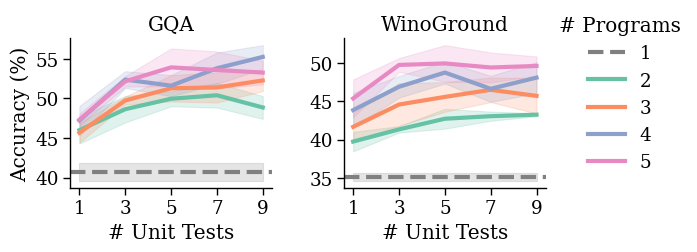

In [14]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 24
plt.figure(figsize=(8,4))
df_num_ut = pd.concat((gqa_num_ut, wg_num_ut))
colors = sns.color_palette('Set2')
colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

g = sns.FacetGrid(df_num_ut, col='Dataset', aspect=1., sharey=False, palette=colors, legend_out=True)
g.map(sns.lineplot, 'num_unit_test', 'acc','num_programs',errorbar='sd', estimator=np.mean, legend=True, palette=colors, linewidth=3, hue_order=[2,3,4,5])
g.set_axis_labels('# Unit Tests', 'Accuracy (%)')
g.set_titles('{col_name}')
g.axes[0,0].set_xticks([1,3,5,7,9])
g.axes[0,0].axhline (base_accuracy_gqa['acc'].mean(), color='gray', linestyle='--', lw=3,label='1 Program')
g.axes[0,0].fill_between([1,9], base_accuracy_gqa['acc'].mean()-base_accuracy_gqa['acc'].std(), base_accuracy_gqa['acc'].mean()+base_accuracy_gqa['acc'].std(), color='gray', alpha=0.2)
g.axes[0,1].axhline(base_accuracy_wg['acc'].mean(), color='gray', linestyle='--', lw=3,label='1 Program')
g.axes[0,1].fill_between([1,9], base_accuracy_wg['acc'].mean()-base_accuracy_wg['acc'].std(), base_accuracy_wg['acc'].mean()+base_accuracy_wg['acc'].std(), color='gray', alpha=0.2)
handles = g._legend_data.values()
for h in handles:
    h.update({'lw': 3})
labels = g._legend_data.keys()
handles = [plt.Line2D([0], [0], color='gray', linestyle='--', lw=3,label='1 Program')] + list(handles)
labels = ['1'] + list(labels)
g.add_legend(handles=handles, labels=labels, title='# Programs', ncols=1)
sns.move_legend(g, loc='upper left', bbox_to_anchor=(0.8,0.93), title='# Programs', ncol=1, frameon=False)
plt.savefig(plot_path+'num_unit_tests.pdf', bbox_inches='tight')

## Penalties

### GQA

In [5]:
all_data = []
for compile_error_penalty in [0.0, 0.1]:
    for runtime_error_penalty in [0.0,0.1]:
        for ut in [1,3,5,7,9]:
            unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty)
            # unit_test_accuracy_gqa = get_folder_accuracy2(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/9_unit_test/'+'5program/run{}', compute='penalyze_error', compile_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, max_unit_tests=9, max_programs=5)
            unit_test_accuracy_gqa['compile_error_penalty'] = compile_error_penalty
            unit_test_accuracy_gqa['runtime_error_penalty'] = runtime_error_penalty
            unit_test_accuracy_gqa['num_unit_test'] = ut
            all_data.append(unit_test_accuracy_gqa)
penalties_gqa  = pd.concat(all_data)

<Figure size 500x500 with 0 Axes>

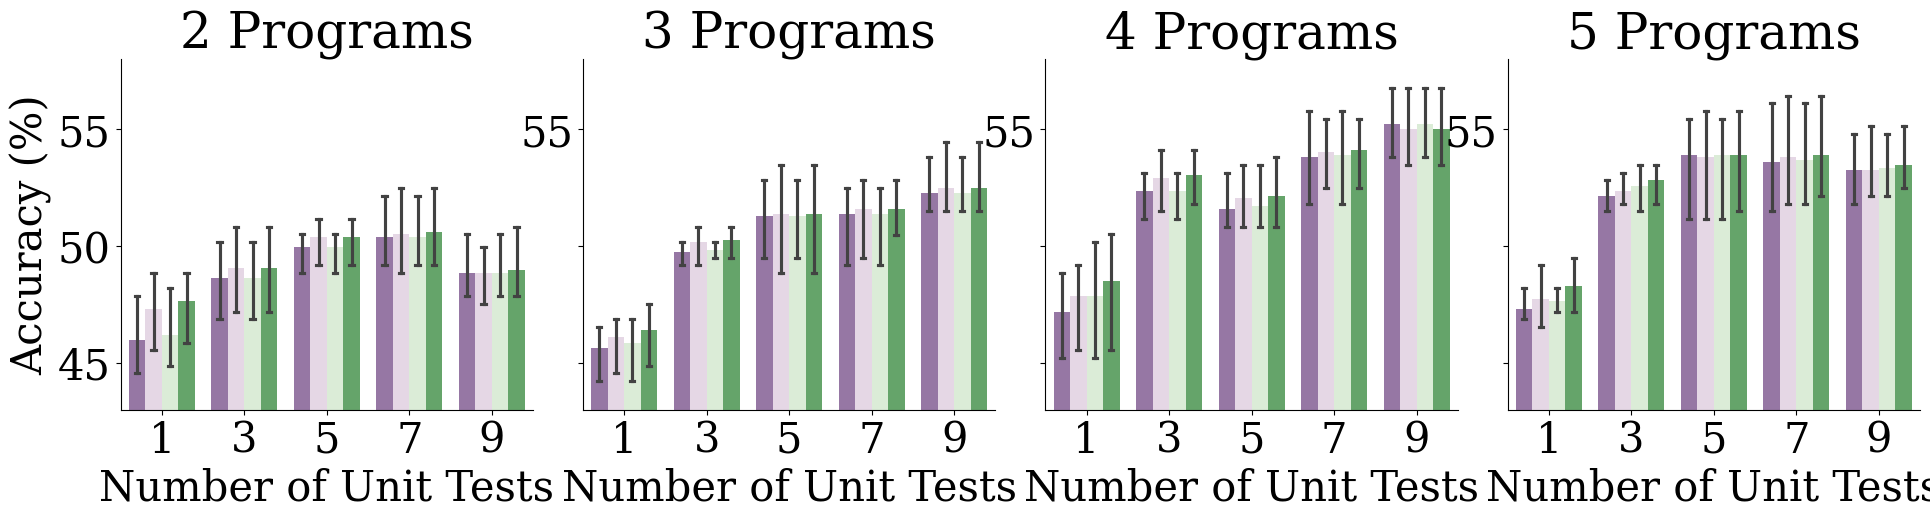

In [6]:
df = penalties_gqa.copy()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
plt.figure(figsize=(5,5))
df['penalties'] = list(zip(df['compile_error_penalty'],df['runtime_error_penalty']))
df['penalties'] = df['penalties'].astype(str)
df.drop(columns=['compile_error_penalty', 'runtime_error_penalty'], inplace=True)
df.rename(columns={'penalties': '(Compilation Error Penalty, Runtime Error Penalty)'}, inplace=True)
hue = '(Compilation Error Penalty, Runtime Error Penalty)'
colorblind_safe_set2 = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"])
g = sns.catplot(data=df,
                y='acc',
                x='num_unit_test', 
                col_wrap=4,
                hue=hue,
                col='num_programs', 
                kind='bar', 
                # estimator=np.median, 
                
                # errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), 
                palette='PRGn',
                capsize=0.2,
                legend=False,
                aspect=1.,
                )
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticks([1,3,5,7,9])
    ax.set_ylim(43,58)
    ax.set_xlabel('Number of Unit Tests')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('{} Programs'.format(ax.get_title().split('=')[-1].strip()))
    
plt.subplots_adjust(top=0.99)  # Increase the space at the top for the suptitle
# sns.move_legend(g, "lower center", bbox_to_anchor=(0.3,-0.04),ncol=4)
# g.fig.suptitle("GQA Accuracy for Different Error Penalties", ha='center', x=0.52)
# plt.show()

plt.savefig(plot_path+'gqa_error_penalties.pdf', dpi=300, bbox_inches='tight')

### WinoGround

In [7]:
all_data = []
for compile_error_penalty in [0.0, 0.1]:
    for runtime_error_penalty in [0.0,0.1]:
        for ut in [1,3,5,7,9]:
            unit_test_accuracy_wg = get_folder_accuracy(f'results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty)
            # unit_test_accuracy_gqa = get_folder_accuracy2(f'results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/'+'5program/run{}', compute='penalyze_error', compile_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, max_unit_tests=9, max_programs=5)
            unit_test_accuracy_wg['compile_error_penalty'] = compile_error_penalty
            unit_test_accuracy_wg['runtime_error_penalty'] = runtime_error_penalty
            unit_test_accuracy_wg['num_unit_test'] = ut
            all_data.append(unit_test_accuracy_wg)
penalties_wg  = pd.concat(all_data)

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x500 with 0 Axes>

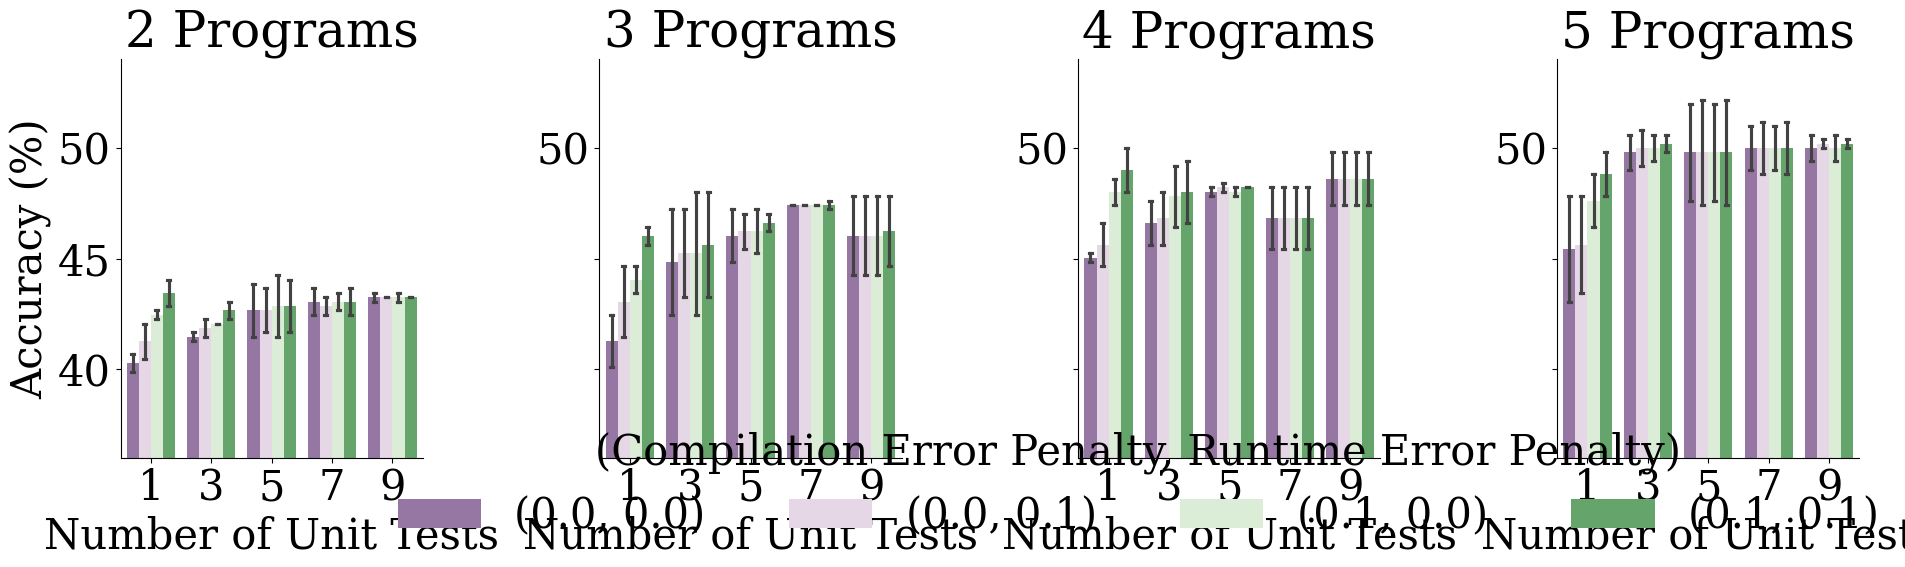

In [8]:
df = penalties_wg.copy()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
plt.figure(figsize=(5,5))
df['penalties'] = list(zip(df['compile_error_penalty'],df['runtime_error_penalty']))
df['penalties'] = df['penalties'].astype(str)
df.drop(columns=['compile_error_penalty', 'runtime_error_penalty'], inplace=True)
df.rename(columns={'penalties': '(Compilation Error Penalty, Runtime Error Penalty)'}, inplace=True)
hue = '(Compilation Error Penalty, Runtime Error Penalty)'
colorblind_safe_set2 = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"])
g = sns.catplot(data=df,
                y='acc',
                x='num_unit_test', 
                col_wrap=4,
                hue=hue,
                col='num_programs', 
                kind='bar', 
                estimator=np.median, 
                errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), 
                palette='PRGn',
                capsize=0.2,
                legend=True,
                aspect=1.,
                )
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticks([1,3,5,7,9])
    ax.set_ylim(36,54)
    ax.set_xlabel('Number of Unit Tests')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('{} Programs'.format(ax.get_title().split('=')[-1].strip()))
    
plt.subplots_adjust(top=0.99)  # Increase the space at the top for the suptitle
sns.move_legend(g, "lower center", bbox_to_anchor=(0.4,-0.04),ncol=4)
# g.fig.suptitle("GQA Accuracy for Different Error Penalties", ha='center', x=0.52)
# plt.show()

plt.savefig(plot_path+'wg_error_penalties.pdf', dpi=300, bbox_inches='tight')

### Combine

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


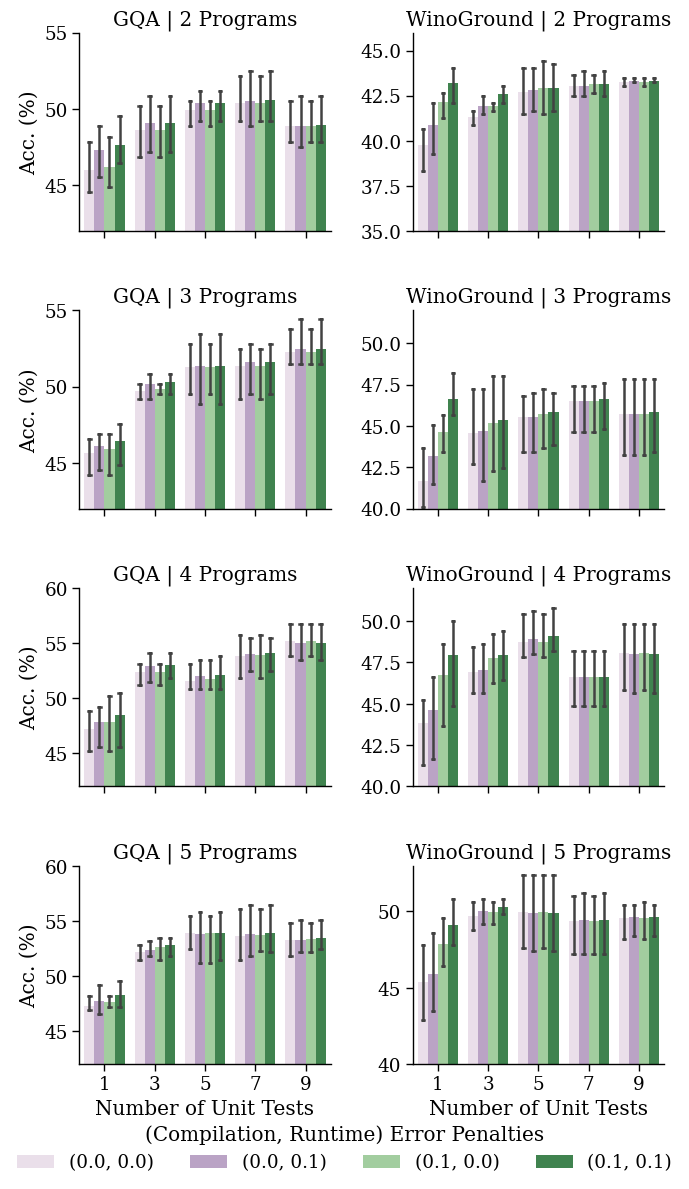

In [12]:
import ast
df_wg = penalties_wg.copy()
df_wg['Dataset'] = 'WinoGround'
df_gqa = penalties_gqa.copy()
df_gqa['Dataset'] = 'GQA'
df = pd.concat([df_gqa, df_wg])
df['(Compile Error Penalty, Runtime Error Penalty)'] = list(zip(df['compile_error_penalty'],df['runtime_error_penalty']))
# df.drop(columns=['compile_error_penalty', 'runtime_error_penalty', 'Dataset'], inplace=True)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
# figure size
hue = '(Compile Error Penalty, Runtime Error Penalty)'

plt.rcParams['figure.figsize'] = [8, 4]
cmap = sns.color_palette('Set2')
# print(df[hue].unique().tolist())
cmap = sns.color_palette('PRGn')
i2col = {
    0: cmap[2],
    1: cmap[1],
    2: cmap[4],
    3: cmap[5],
    4: cmap[2],
    5: cmap[1],
    6: cmap[4],
    7: cmap[5]
}
hue_val_two_color = {k:i2col[i] for i,k in enumerate(df[hue].unique().tolist())}

color_list = [cmap[2],cmap[1],cmap[4],cmap[5]] #+  [cmap[2],cmap[1],cmap[4],cmap[5]]

g = sns.FacetGrid(df, col="Dataset", row='num_programs', sharey=False,  aspect=1.2)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", hue, palette=color_list, legend=True, capsize=0.2, dodge=True)


g.axes[0,0].set_ylim(42,55)
g.axes[1,0].set_ylim(42,55)
g.axes[2,0].set_ylim(42,60)
g.axes[3,0].set_ylim(42,60)
g.axes[0,1].set_ylim(35,46)
g.axes[1,1].set_ylim(40,52)
g.axes[2,1].set_ylim(40,52)
g.axes[3,1].set_ylim(40,53)

g.set_axis_labels("Number of Unit Tests", "Acc. (%)")
g.set_titles("{col_name} | {row_name} Programs")

g.add_legend()
sns.move_legend(g, "lower center", title="(Compilation, Runtime) Error Penalties" ,bbox_to_anchor=(0.45,-0.02),ncol=4)
plt.savefig(plot_path+'gqa_winoground_penalties_all.pdf', dpi=300, bbox_inches='tight')


## Aggregator

### GQA

In [18]:
all_data = []
aggregators = {'mean': np.mean, 'median': np.median, 'max': np.max, 'min': np.min}
for aggretator in ['mean', 'median', 'max', 'min']:
        for ut in [1,3,5,7,9]:
            unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, aggregator=aggregators[aggretator])
            # unit_test_accuracy_gqa = get_folder_accuracy2(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/9_unit_test/'+'5program/run{}', compute='penalyze_error', compile_error_penalty=compile_error_penalty, runtime_error_penalty=runtime_error_penalty, max_unit_tests=9, max_programs=5)
            unit_test_accuracy_gqa['aggregator'] = aggretator
            unit_test_accuracy_gqa['num_unit_test'] = ut
            all_data.append(unit_test_accuracy_gqa)
aggregators_gqa  = pd.concat(all_data)

<Figure size 500x500 with 0 Axes>

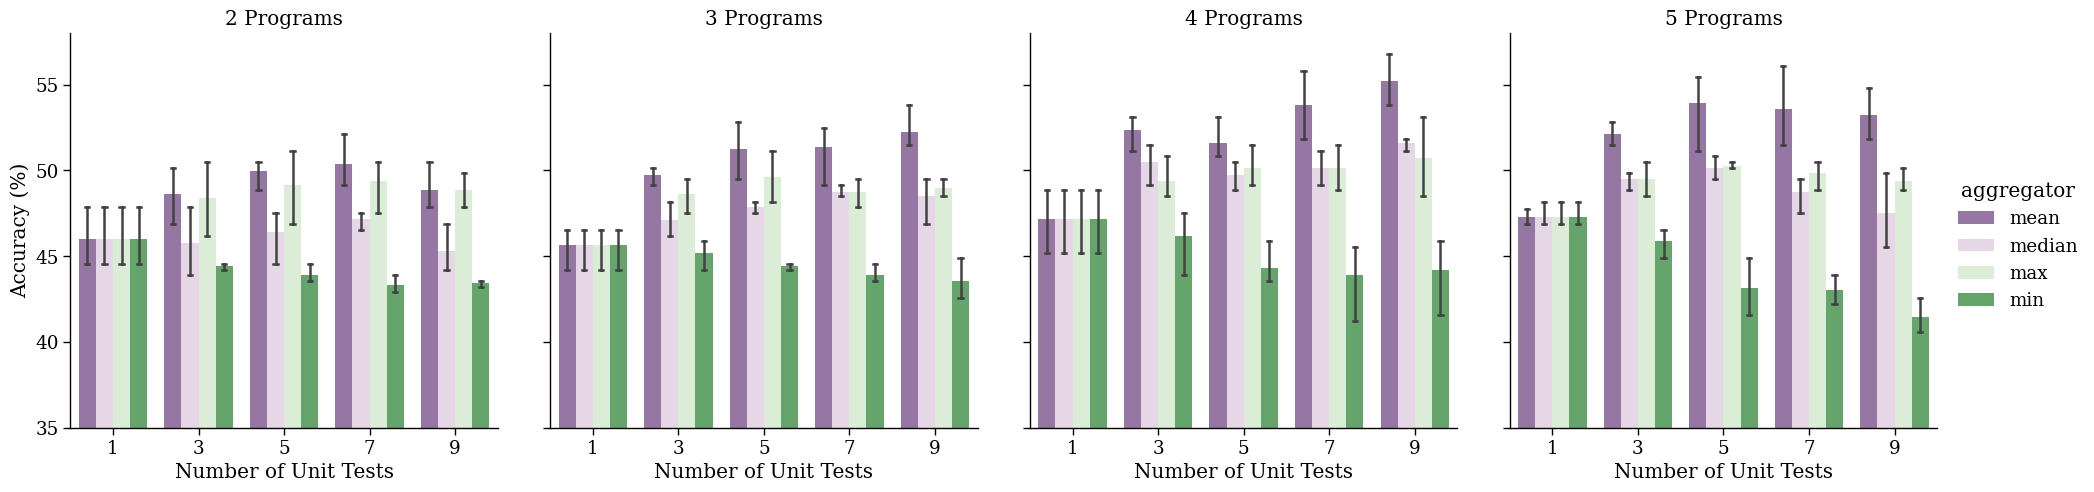

In [30]:
df = aggregators_gqa.copy()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
plt.figure(figsize=(5,5))
hue = 'aggregator'
colorblind_safe_set2 = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"])
g = sns.catplot(data=df,
                y='acc',
                x='num_unit_test', 
                col_wrap=4,
                hue=hue,
                col='num_programs', 
                kind='bar', 
                # estimator=np.median, 
                
                # errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), 
                palette='PRGn',
                capsize=0.2,
                legend=True,
                aspect=1.,
                )
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticks([1,3,5,7,9])
    ax.set_ylim(35,58)
    ax.set_xlabel('Number of Unit Tests')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('{} Programs'.format(ax.get_title().split('=')[-1].strip()))
    
plt.subplots_adjust(top=0.99)  # Increase the space at the top for the suptitle
# sns.move_legend(g, "lower center", bbox_to_anchor=(0.3,-0.04),ncol=4)
# plt.show()

plt.savefig(plot_path+'gqa_error_aggregator.pdf', dpi=300, bbox_inches='tight')

### WinoGround

In [25]:
all_data = []
aggregators = {'mean': np.mean, 'median': np.median, 'max': np.max, 'min': np.min}
for aggretator in ['mean', 'median', 'max', 'min']:
        for ut in [1,3,5,7,9]:
            unit_test_accuracy_wg = get_folder_accuracy(f'results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, aggregator=aggregators[aggretator])
            unit_test_accuracy_wg['aggregator'] = aggretator
            unit_test_accuracy_wg['num_unit_test'] = ut
            all_data.append(unit_test_accuracy_wg)
aggregators_wg  = pd.concat(all_data)

<Figure size 500x500 with 0 Axes>

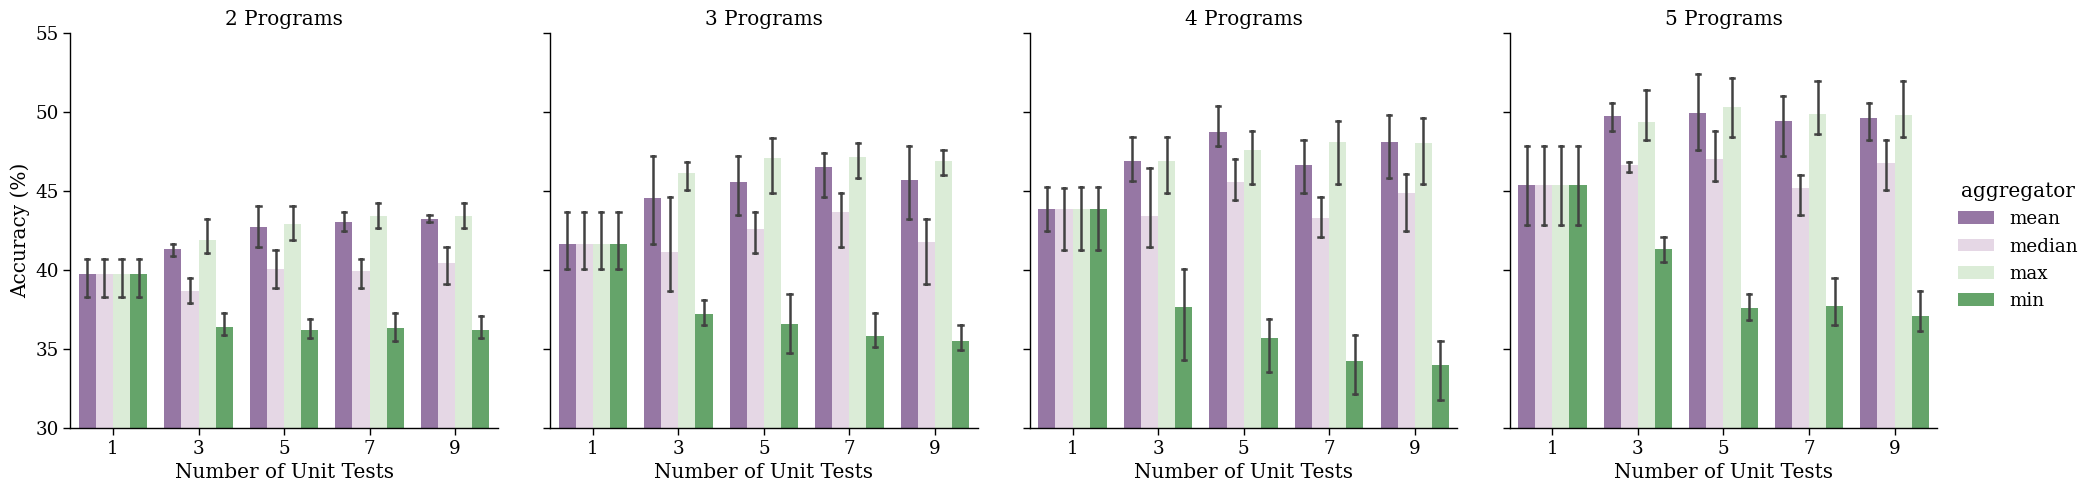

In [ ]:
df = aggregators_wg.copy()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
plt.figure(figsize=(5,5))
hue = 'aggregator'
colorblind_safe_set2 = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"])
g = sns.catplot(data=df,
                y='acc',
                x='num_unit_test', 
                col_wrap=4,
                hue=hue,
                col='num_programs', 
                kind='bar', 
                # estimator=np.median, 
                
                # errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), 
                palette='PRGn',
                capsize=0.2,
                legend=True,
                aspect=1.,
                )
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticks([1,3,5,7,9])
    ax.set_ylim(30,55)
    ax.set_xlabel('Number of Unit Tests')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('{} Programs'.format(ax.get_title().split('=')[-1].strip()))
    
plt.subplots_adjust(top=0.99)  # Increase the space at the top for the suptitle
# sns.move_legend(g, "lower center", bbox_to_anchor=(0.3,-0.04),ncol=4)
# plt.show()

plt.savefig(plot_path+'wg_error_aggregator.pdf', dpi=300, bbox_inches='tight')

### Combine

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


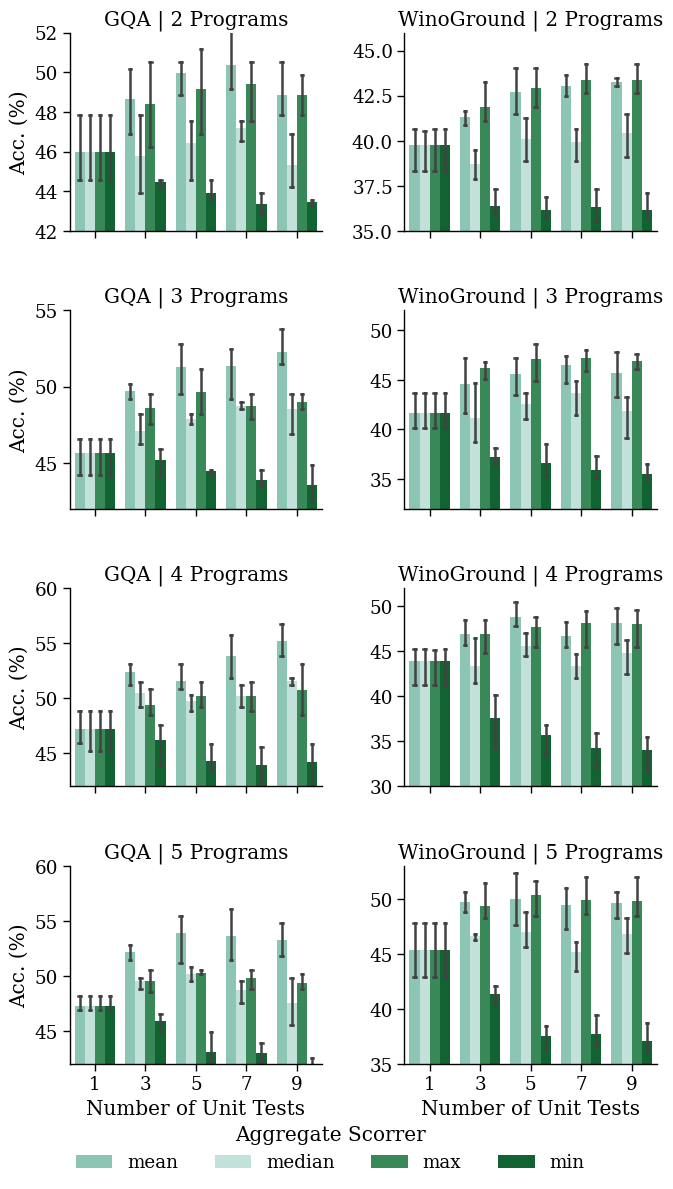

In [38]:
import ast
df_wg = aggregators_wg.copy()
df_wg['Dataset'] = 'WinoGround'
df_gqa = aggregators_gqa.copy()
df_gqa['Dataset'] = 'GQA'
df = pd.concat([df_gqa, df_wg])
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 30
# figure size
hue = 'aggregator'

plt.rcParams['figure.figsize'] = [8, 4]
cmap = sns.color_palette('Set2')
# print(df[hue].unique().tolist())
cmap = sns.color_palette('BuGn')
i2col = {
    0: cmap[2],
    1: cmap[1],
    2: cmap[4],
    3: cmap[5],
    4: cmap[2],
    5: cmap[1],
    6: cmap[4],
    7: cmap[5]
}
hue_val_two_color = {k:i2col[i] for i,k in enumerate(df[hue].unique().tolist())}

color_list = [cmap[2],cmap[1],cmap[4],cmap[5]] #+  [cmap[2],cmap[1],cmap[4],cmap[5]]

g = sns.FacetGrid(df, col="Dataset", row='num_programs', sharey=False,  aspect=1.2)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", hue, palette=color_list, legend=True, capsize=0.2, dodge=True)


g.axes[0,0].set_ylim(42,52)
g.axes[1,0].set_ylim(42,55)
g.axes[2,0].set_ylim(42,60)
g.axes[3,0].set_ylim(42,60)
g.axes[0,1].set_ylim(35,46)
g.axes[1,1].set_ylim(32,52)
g.axes[2,1].set_ylim(30,52)
g.axes[3,1].set_ylim(35,53)

g.set_axis_labels("Number of Unit Tests", "Acc. (%)")
g.set_titles("{col_name} | {row_name} Programs")

g.add_legend()
sns.move_legend(g, "lower center", title="Aggregate Scorrer" ,bbox_to_anchor=(0.45,-0.02),ncol=4)
plt.savefig(plot_path+'gqa_winoground_aggregators_all.pdf', dpi=300, bbox_inches='tight')


## Sampling

### GQA

In [20]:
# data = pickle.load(open('./results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/1_unit_test/2program/run1/data.p', 'rb'))
reverse_dict_gqa = {
    # Attribute
    'categoryAttr': 'Attribute',
    'chooseAttr': 'Attribute',
    'verifyAttr': 'Attribute',
    'verifyAttrAnd': 'Attribute',
    'verifyAttrC': 'Attribute',
    'verifyAttrCThis': 'Attribute',
    'verifyAttrK': 'Attribute',
    'verifyAttrKC': 'Attribute',
    'verifyAttrThis': 'Attribute',
    'verifyAttrs': 'Attribute',
    'verifyAttrsC': 'Attribute',
    'existAttr': 'Attribute',
    'existAttrC': 'Attribute',
    'existAttrNot': 'Attribute',
    'existAttrNotC': 'Attribute',
    'existAttrOr': 'Attribute',
    'existAttrOrC': 'Attribute',
    'twoCommon': 'Attribute',
    'twoDifferent': 'Attribute',
    'twoDifferentC': 'Attribute',
    'twoSame': 'Attribute',
    'twoSameC': 'Attribute',
    'twoSameMaterial': 'Attribute',
    'twoSameMaterialC': 'Attribute',
    'existMaterial': 'Attribute',
    'existMaterialC': 'Attribute',
    'existMaterialNot': 'Attribute',
    'existMaterialNotC': 'Attribute',
    'categoryThat': 'Attribute',
    'categoryThatChoose': 'Attribute',
    'sameGender': 'Attribute',
    'sameGenderC': 'Attribute',
    'sameMaterialRelate': 'Attribute',
    'state': 'Attribute',
    'stateChoose': 'Attribute',
    'material': 'Attribute',
    'materialChoose': 'Attribute',
    'materialVerify': 'Attribute',
    'materialVerifyC': 'Attribute',
    'sameRelate': 'Attribute',
    'existThat': 'Attribute',
    'existThatC': 'Attribute',
    'existThatNot': 'Attribute',
    'existThatNotC': 'Attribute',
    'existThatOr': 'Attribute',
    'existThatOrC': 'Attribute',
    'verifyMaterialAnd': 'Attribute',
    'comparativeChoose': 'Attribute',
    
    
    'typeChoose': 'Category',
    'typeVerify': 'Category',
    'typeVerifyC': 'Category',
    'existAnd': 'Category',
    'existAndC': 'Category',
    'existOr': 'Category',
    'existOrC': 'Category',
    'exist': 'Category',
    'existC': 'Category',
    'diffAnimals': 'Category',
    'diffAnimalsC': 'Category',
    'sameAnimals': 'Category',
    'sameAnimalsC': 'Category',
    'objThisChoose': 'Category',
    'category': 'Category',
    'categoryThis': 'Category',
    'categoryThisChoose': 'Category',
    
    
    'activity': 'Category',
    'activityChoose': 'Category',
    'activityWho': 'Category',
    'company': 'Category',
    'companyVerify': 'Category',
    'how': 'Attribute',
    'weather': 'Attribute',
    'weatherChoose': 'Attribute',
    'weatherVerify': 'Attribute',
    'weatherVerifyC': 'Attribute',

    'categoryRelO': 'Spatial',
    'categoryRelOChoose': 'Spatial',
    'categoryRelS': 'Spatial',
    'existRelS': 'Spatial',
    'existRelSC': 'Spatial',
    'existRelSRC': 'Spatial',
    'relChooser': 'Spatial',
    'relO': 'Spatial',
    'relS': 'Spatial',
    'relVerify': 'Spatial',
    'relVerifyCo': 'Spatial',
    'relVerifyCop': 'Spatial',
    'relVerifyCr': 'Spatial',
    'place': 'Spatial',
    'placeChoose': 'Spatial',
    'placeVerify': 'Spatial',
    'placeVerifyC': 'Spatial',
    'positionChoose': 'Spatial',
    'positionQuery': 'Spatial',
    'positionVerify': 'Spatial',
    'positionVerifyC': 'Spatial',
    'locationVerify': 'Spatial',
    'locationVerifyC': 'Spatial',
    'locationChoose': 'Spatial',
    'directOf': 'Spatial',
    'directWhich': 'Spatial',
    'dir': 'Spatial',
}


In [ ]:
all_data = []
for ut in [1,3,5,7,9]:
    random_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    random_sampling['num_unit_test'] = ut
    random_sampling['sampling'] = 'Random'
    all_data.append(random_sampling)
    
    coverage_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    coverage_sampling['num_unit_test'] = ut
    coverage_sampling['sampling'] = 'Coverage By Answer then Input'
    all_data.append(coverage_sampling)
    
    answer_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_by_answer_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    answer_sampling['num_unit_test'] = ut
    answer_sampling['sampling'] = 'Coverage By Answer'
    all_data.append(answer_sampling)
    
    input_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_by_input_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    input_sampling['num_unit_test'] = ut
    input_sampling['sampling'] = 'Coverage By Input'
    all_data.append(input_sampling)
    
sampling_gqa = pd.concat(all_data)

In [ ]:
# all_data_type = []
# from tqdm import tqdm
# for g in tqdm(reversed_items.keys()):
#     for ut in [1,3,5,7,9]:
#         random_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', filter={'group':g}, compile_error_penalty=0.0, runtime_error_penalty=0.0)
#         random_sampling['num_unit_test'] = ut
#         random_sampling['sampling'] = 'Random'
#         random_sampling['type'] = g
#         all_data_type.append(random_sampling)
        
#         coverage_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', filter={'group':g}, compile_error_penalty=0.0, runtime_error_penalty=0.0)
#         coverage_sampling['num_unit_test'] = ut
#         coverage_sampling['sampling'] = 'Coverage By Answer then Input'
#         coverage_sampling['type'] = g
#         all_data_type.append(coverage_sampling)
        
#         answer_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_by_answer_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', filter={'group':g},compile_error_penalty=0.0, runtime_error_penalty=0.0)
#         answer_sampling['num_unit_test'] = ut
#         answer_sampling['sampling'] = 'Coverage By Answer'
#         answer_sampling['type'] = g
#         all_data_type.append(answer_sampling)
        
#         input_sampling = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_coverage_by_input_corr/{ut}_unit_test/'+'{}program/run{}', compute='penalyze_error', filter={'group':g},compile_error_penalty=0.0, runtime_error_penalty=0.0)
#         input_sampling['num_unit_test'] = ut
#         input_sampling['sampling'] = 'Coverage By Input'
#         input_sampling['type'] = g
#         all_data_type.append(input_sampling)
    
# sampling_gqa = pd.concat(all_data_type)
# sampling_gqa.to_csv('results/sampling_gqa.csv')

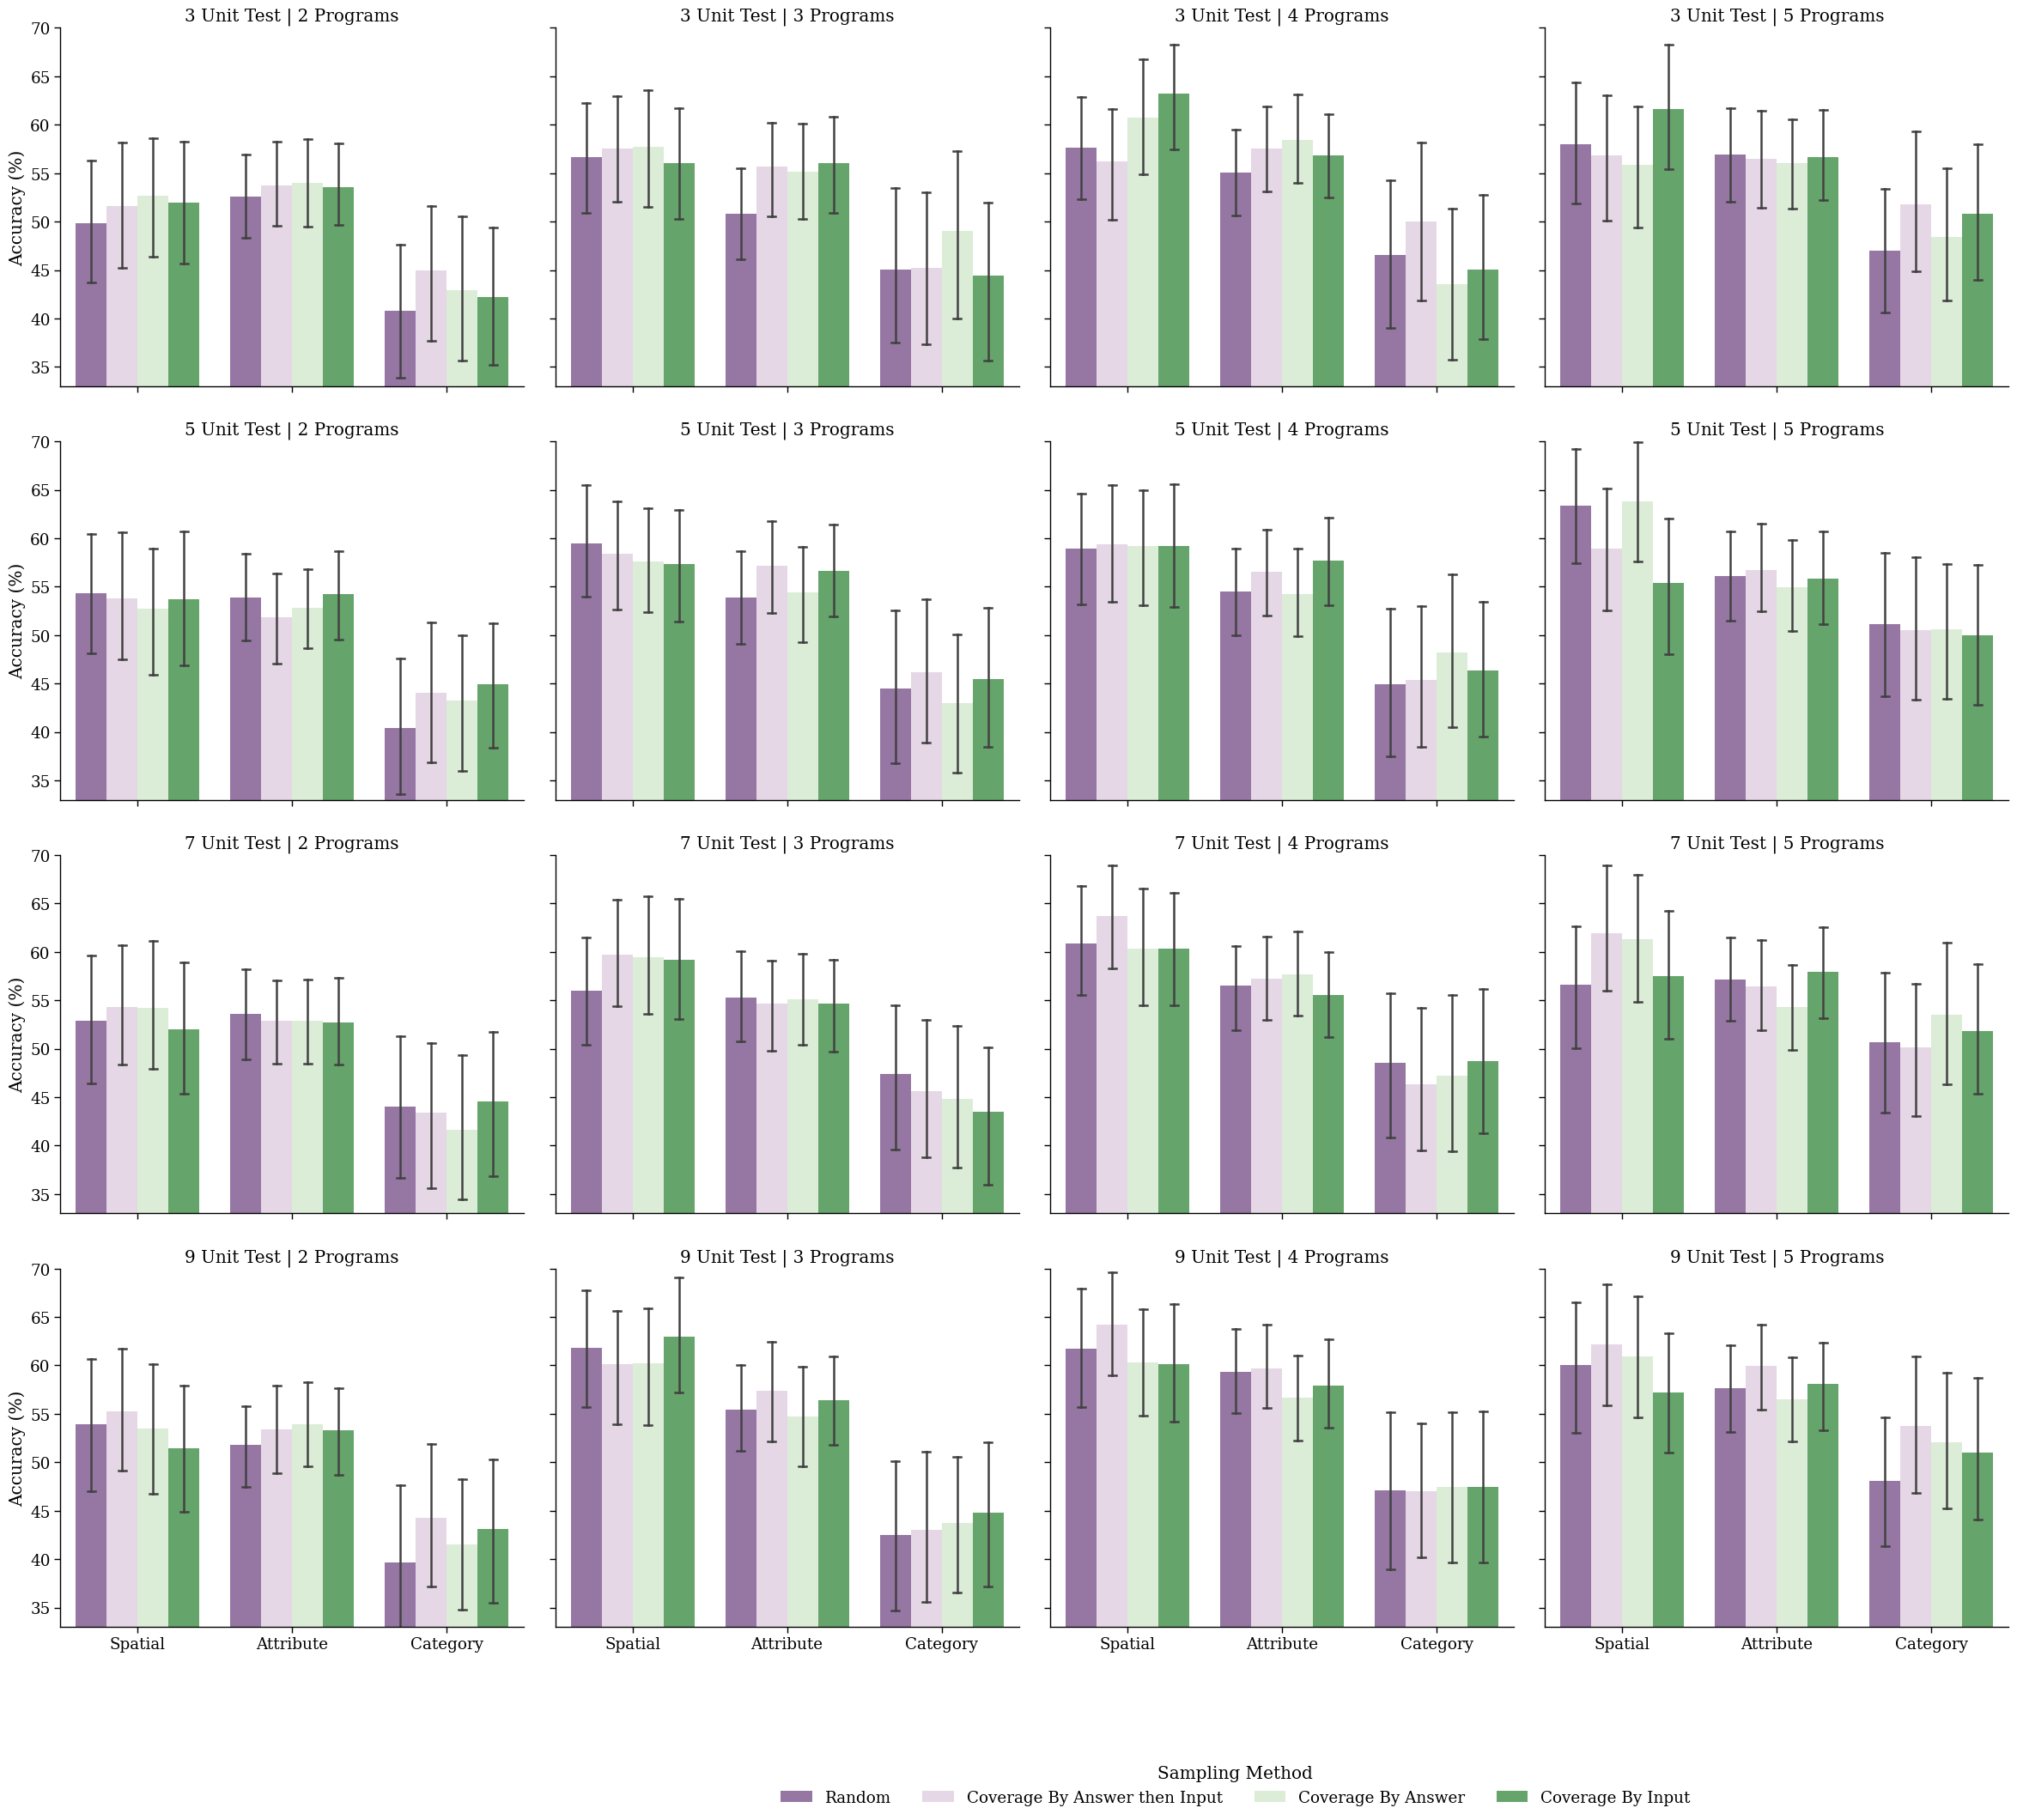

In [ ]:
df = pd.read_csv('results/sampling_gqa.csv')
df.replace(reverse_dict, inplace=True)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [10, 5]

# df = df[df['num_unit_test'] > 7]
# df = df[df['num_programs'] > 2]

max_count = df[df['sampling'] == 'Max Count']
df = df[df['sampling'] != 'Max Count']
df = df[df['sampling'] != 'Upper Bound']
# df = df[df['type'].isin(['Attribute','Spatial',  'Category'])]
# df = df[df['type'].isin(list(reversed_items.keys())[80:])]
sorted_data = df.sort_values(by="acc", ascending=False)

# df = df[df['num_programs'] == 5]
first_non_error = df[df['sampling'] == 'First Non-Error']
df = df[df['sampling'] != 'First Non-Error']
df =df[df['num_unit_test'] != 1]
# df = df[df['type'].isin(existAttr_groups)]
col = 'num_programs' 
x = 'num_unit_test'
hue = 'sampling'
df = df
df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
# Set up a FacetGrid to create separate plots for each num_programs
# palette = [palette[0], palette[4], palette[5]]
# g = sns.FacetGrid(df,col='num_programs', row='num_unit_test', hue=hue, sharey=False, aspect=1.3, palette='PRGn')
# g.map(sns.barplot, 'type', 'acc', capsize=0.2, estimator=np.mean, errorbar='sd', dodge=True)

g = sns.catplot(
    data=df,
    # col_wrap=10,
    col = 'num_programs',
    row='num_unit_test',
    # col='num_unit_test',
    x='type', y='acc', hue=hue,
    kind='bar', #height=4, aspect=1.8,
    capsize=0.2,  # Size of the caps on error bars
    dodge=True,
    legend=True,
    palette='PRGn',
    aspect=1.2)

g.set_titles(template="{row_name} Unit Test | {col_name} Programs")
g.set_axis_labels("", "Accuracy (%)")
# set ylimits
g.set(ylim=(33,70))
sns.move_legend(g,title='Sampling Method', loc='lower right', bbox_to_anchor=(0.73,-0.07), ncols=5)
# Show the plot
plt.savefig(plot_path+'gqa_sampling_methods_cateogires.pdf', dpi=300, bbox_inches='tight')

### WinoGround

In [21]:
# wg_data = pickle.load(open('/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/1_unit_test/'+'2program/run1/data.p', 'rb'))
# tags = list(set([d['tag'] for d in wg_data]))
# collapsed_tags = list(set([d['collapsed_tag'] for d in wg_data]))
# secondary_tags = list(set([d['secondary_tag'] for d in wg_data]))
reverse_dict_wg = {
    # Category
    "Pronoun, Noun Phrase": "Attribute",
    "Noun Phrase": "Attribute",
    "Noun Phrase, Determiner-Numeral": "Attribute",
    "Determiner-Numeral": "Category",
    "Determiner-Possessive": "Category",
    "Determiner-Numeral Phrase": "Category",
    "Determiner-Numeral, Noun Phrase": "Category",
    "Noun": "Category",
    "Noun, Adjective-Color": "Attribute",
    "Noun, Adjective-Size": "Attribute",
    "Noun, Verb-Intransitive": "Spatial",
    "Noun Phrase, Determiner-Possessive": "Category",
    "Noun Phrase, Adjective-Color": "Attribute",
    "Sentence": "Attribute",
    "Scope": "Attribute",
    "Scope, Conjunction": "Attribute",
    "Scope, Conjunction Phrase": "Attribute",
    "Scope, Relative Clause": "Attribute",
    "Scope, Noun, Preposition": "Spatial",

    # Attribute
    "Adjective-Animate": "Attribute",
    "Noun Phrase, Adjective-Animate": "Attribute",
    "Adjective-Color": "Attribute",
    "Adjective-Color (3-way swap)": "Attribute",
    "Adjective-Speed": "Attribute",
    "Adjective-Speed Phrase, Verb-Intransitive": "Attribute",
    "Adjective-Size": "Attribute",
    "Adjective-Height": "Attribute",
    "Adjective-Shape": "Attribute",
    "Adjective-Temperature": "Attribute",
    "Adjective-Texture": "Attribute",
    "Adjective-Temporal": "Attribute",
    "Adjective-Weight": "Attribute",
    "Adjective-Manner": "Attribute",
    "Adjective-Manner Phrase": "Attribute",
    "Adjective-Age": "Attribute",
    "Adverb-Animate": "Attribute",
    "Adverb-Temporal": "Attribute",
    "Verb-Transitive": "Spatial",
    "Verb-Intransitive": "Attribute",
    "Verb-Intransitive, Noun": "Spatial",
    "Verb-Transitive Phrase": "Category",
    "Verb-Intransitive Phrase": "Attribute",
    "Verb-Intransitive Phrase, Adverb-Animate": "Attribute",
    "Verb-Intransitive Phrase, Preposition": "Spatial",
    "Verb-Transitive, Noun": "Spatial",
    "Verb-Intransitive, Verb-Transitive Phrase": "Spatial",
    "Verb-Intransitive, Determiner-Numeral": "Attribute",
    "Verb-Intransitive, Adjective-Manner": "Attribute",
    "Scope, Adjective-Manner": "Attribute",
    "Scope, Verb-Transitive": "Attribute",
    "Scope, Adjective-Texture": "Attribute",
    "Negation, Scope": "Attribute",
    "Negation, Noun Phrase, Preposition Phrase": "Attribute",
    "Altered POS": "Category",
    "Altered POS, Determiner-Numeral": "Category",
    "Scope, Altered POS, Verb-Intransitive, Verb-Transitive": "Attribute",

    # Spatial
    "Preposition": "Spatial",
    "Preposition Phrase": "Spatial",
    "Scope, Preposition": "Spatial",
    "Scope, Preposition, Verb-Intransitive": "Spatial",
    "Preposition Phrase, Scope": "Spatial",
    "Scope, Preposition Phrase": "Spatial",
    "Scope, Preposition Phrase, Adjective-Color": "Spatial",
    "Adverb-Spatial": "Spatial",
    "Adverb-Spatial Phrase": "Spatial",
    "Adjective-Spatial": "Spatial",
    "Noun, Preposition Phrase, Scope": "Spatial",
    "Relative Clause, Scope": "Attribute",
    "Verb-Transitive Phrase, Verb-Intransitive, Preposition Phrase": "Spatial",
    "Pronoun, Verb-Intransitive": "Attribute",
}


In [ ]:
all_data = []
from tqdm import tqdm
for t in tqdm(tags):
#     for ct in collapsed_tags:
#         for st in secondary_tags:
    for ut in [1,3,5,7,9]:
        random_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag':t})
        random_sampling['num_unit_test'] = ut
        random_sampling['sampling'] = 'Random'
        # random_type = f'{t}_{ct}_{st}'
        random_sampling['type'] = t
        all_data.append(random_sampling)
        
        coverage_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage_by_answer_then_input/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag':t})
        coverage_sampling['num_unit_test'] = ut
        coverage_sampling['sampling'] = 'Coverage By Answer then Input'
        # coverage_type = f'{t}_{ct}_{st}'
        coverage_sampling['type'] = t
        all_data.append(coverage_sampling)
        
        answer_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage_by_answer/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag':t})
        answer_sampling['num_unit_test'] = ut
        answer_sampling['sampling'] = 'Coverage By Answer'
        # answer_type = f'{t}_{ct}_{st}'
        answer_sampling['type'] = t
        all_data.append(answer_sampling)
        
        input_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag':t})
        input_sampling['num_unit_test'] = ut
        input_sampling['sampling'] = 'Coverage By Input'
        # input_type = f'{t}_{ct}_{st}'
        input_sampling['type'] = t
        all_data.append(input_sampling)
    
sampling_wg_type = pd.concat(all_data)
sampling_wg.to_csv('results/sampling_wg_tags.csv')

In [ ]:
all_data = []
for ut in [1,3,5,7,9]:
    random_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    random_sampling['num_unit_test'] = ut
    random_sampling['sampling'] = 'Random'
    # random_type = f'{t}_{ct}_{st}'
    # random_sampling['type'] = t
    all_data.append(random_sampling)
    
    coverage_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage_by_answer_then_input/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    coverage_sampling['num_unit_test'] = ut
    coverage_sampling['sampling'] = 'Coverage By Answer then Input'
    # coverage_type = f'{t}_{ct}_{st}'
    # coverage_sampling['type'] = t
    all_data.append(coverage_sampling)
    
    answer_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage_by_answer/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    answer_sampling['num_unit_test'] = ut
    answer_sampling['sampling'] = 'Coverage By Answer'
    # answer_type = f'{t}_{ct}_{st}'
    # answer_sampling['type'] = t
    all_data.append(answer_sampling)
    
    input_sampling = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp_coverage/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    input_sampling['num_unit_test'] = ut
    input_sampling['sampling'] = 'Coverage By Input'
    # input_type = f'{t}_{ct}_{st}'
    # input_sampling['type'] = t
    all_data.append(input_sampling)

sampling_wg = pd.concat(all_data)

### Combine

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


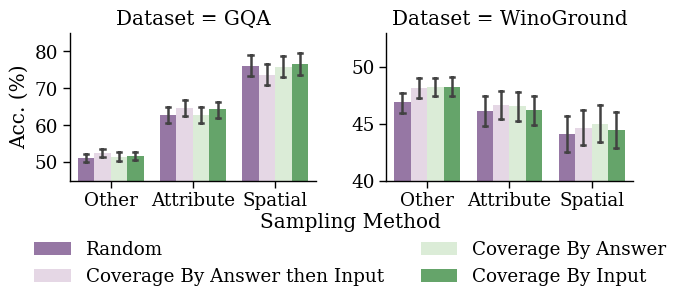

In [46]:
gqa = pd.read_csv('results/sampling_gqa.csv')
gqa_types = gqa['type'].unique().tolist()
def map_gqa(t):
    if any([k in t.lower() for k in ['attr']]):
        return 'Attribute'
    if any([k in t.lower() for k in ['location', 'position']]):
        return 'Spatial'
    else:
        return 'Other'
gqa['type'] = gqa['type'].apply(map_gqa)
# gqa.replace(reverse_dict_gqa, inplace=True)
gqa['Dataset'] = 'GQA'
wg = pd.read_csv('results/sampling_wg_tags.csv')
wg['Dataset'] = 'WinoGround'
def map_wg(t):
    if any([k in t.lower() for k in ['adjective']]):
        return 'Attribute'
    if any([k in t.lower() for k in ['preposition', 'spatial']]):
        return 'Spatial'
    else:
        return 'Other'
# wg.replace(reverse_dict, inplace=True)
wg['type'] = wg['type'].apply(map_wg)
df = pd.concat([gqa,wg])
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [6, 8]

# df = df[df['num_unit_test'] > ]
df = df[df['num_programs'] > 2]

max_count = df[df['sampling'] == 'Max Count']
df = df[df['sampling'] != 'Max Count']
df = df[df['sampling'] != 'Upper Bound']
# df = df[df['type'].isin(['Attribute','Spatial',  'Category'])]
# df = df[df['type'].isin(list(reversed_items.keys())[80:])]
sorted_data = df.sort_values(by="acc", ascending=False)

# df = df[df['num_programs'] == 5]
first_non_error = df[df['sampling'] == 'First Non-Error']
df = df[df['sampling'] != 'First Non-Error']
df =df[df['num_unit_test'] > 1]
# df = df[df['type'].isin(existAttr_groups)]
col = 'num_programs' 
x = 'num_unit_test'
hue = 'sampling'
df = df
df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
g = sns.FacetGrid(df, col="Dataset", sharey=False,  aspect=1.2)  # Explicitly setting sharey=False
g.map(sns.barplot, "type", "acc", hue, palette='PRGn', legend=True, capsize=0.2, dodge=True)

g.set_axis_labels("", "Acc. (%)")
g.axes[0,0].set_ylim(45,85)
g.axes[0,1].set_ylim(40,53)
# g.axes[1,1].set_ylim(40,55)
# g.axes[2,1].set_ylim(40,55)
# g.axes[3,1].set_ylim(40,53)

# set ylimits
g.add_legend()
# g.set(ylim=(40,70))
sns.move_legend(g,title='Sampling Method', loc='lower right', bbox_to_anchor=(0.7,-0.1), ncols=2)
# g.fig.suptitle("GQA Accuracy for Different Sampling Methods")

# Show the plot
plt.savefig(plot_path+'gqa_wg_sampling_methods_cateogires.pdf', dpi=300, bbox_inches='tight')

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/s

<Figure size 500x500 with 0 Axes>

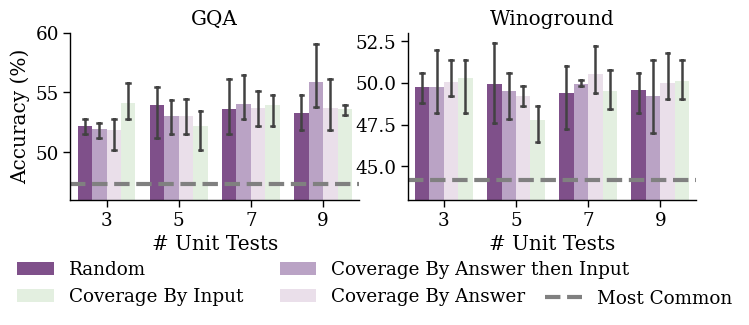

In [ ]:
# sampling_gqa = pd.read_csv('results/sampling_gqa.csv')
# sampling_wg = pd.read_csv('results/sampling_wg_tags.csv')

# sampling_gqa = sampling_gqa_attr.copy()
# sampling_wg = sampling_wg_attr.copy()
# sampling_gqa = sampling_gqa_old.copy()
# sampling_wg = sampling_wg_old.copy()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams['font.size'] =30
sampling_gqa['Dataset'] = 'GQA'
sampling_wg['Dataset'] = 'Winoground'
# acc relative to base
# def acc_relative_to_base_gqa(row):
#     base_data = base_accuracy_gqa[base_accuracy_gqa['num_programs'] == 1]
#     base_acc = base_data[base_data['run'] == row['run']]['acc'].values[0]
#     return 100* (row['acc'] - base_acc)/base_acc
# ## apply to rows
# sampling_gqa['acc'] = sampling_gqa.apply(acc_relative_to_base_gqa, axis=1)
# def acc_relative_to_base_wg(row):
#     base_data = base_accuracy_wg[base_accuracy_wg['num_programs'] == 1]
#     base_acc = base_data[base_data['run'] == row['run']]['acc'].values[0]
#     return 100* (row['acc'] - base_acc)/base_acc
# sampling_wg['acc'] = sampling_wg.apply(acc_relative_to_base_wg, axis=1)
sampling_both = pd.concat([sampling_gqa, sampling_wg])

plt.rcParams['font.size'] = 12
plt.figure(figsize=(5,5))

# sampling_both['hue'] = sampling_both['sampling'] + ' ' + sampling_both['Dataset']
sampling_both = sampling_both[sampling_both['num_unit_test'] != 1]
sampling_both = sampling_both[sampling_both['num_programs'] == 5]
sampling_both['Sampling'] = sampling_both['sampling']
sampling_both.drop(columns=['num_programs', 'sampling'], inplace=True)
# num_unit_test is int
sampling_both = sampling_both.astype({'num_unit_test': 'int'}, copy=False)
cmap = sns.color_palette('PRGn')
# sampling_both.rename({"Coverage By Answer": "By Answer", "Coverage By Input": "By Input", "Coverage By Answer then Input": "By Answer then Input"}, inplace=True)
g = sns.FacetGrid(sampling_both, col="Dataset", sharey=False,  aspect=1.3)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", "Sampling", palette=cmap, legend=True, capsize=0.2, dodge=True)
g.set_axis_labels("# Unit Tests", "Accuracy (%)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g.axes[0,0].axhline (max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean(), color='gray', linestyle='--', lw=3,label='Most Common Answer')
most_common_answer_std = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].std()
most_common_answer_mean = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean()
# g.axes[0,0].fill_between([0,1,2,3],most_common_answer_mean-most_common_answer_std, most_common_answer_mean+most_common_answer_std, color='gray', alpha=0.2)

most_common_answer_wg = max_count_accuracy_wg[max_count_accuracy_wg['num_programs']==5]['acc'].mean()
g.axes[0,1].axhline (most_common_answer_wg, color='gray', linestyle='--', lw=3,label='Most Common Answer')
most_common_answer_std_wg = max_count_accuracy_wg[max_count_accuracy_wg['num_programs']==5]['acc'].std()
# g.axes[0,1].fill_between([0,1,2,3],most_common_answer_wg-most_common_answer_std_wg, most_common_answer_wg+most_common_answer_std_wg, color='gray', alpha=0.2)

# g.axes[0,0].axhline (base_accuracy_gqa['acc'].mean(), color='gray', linestyle='--', lw=3,label='Base Setup')
g.axes[0,0].set_ylim(46,60)
# g.axes[0,0].fill_between([3,5,7,9], base_accuracy_gqa['acc'].mean()-base_accuracy_gqa['acc'].std(), base_accuracy_gqa['acc'].mean()+base_accuracy_gqa['acc'].std(), color='gray', alpha=0.2)
# g.axes[0,1].axhline(base_accuracy_wg['acc'].mean(), color='gray', linestyle='--', lw=3,label='Base Setup')
# g.axes[0,1].fill_between([3,5,7,9], base_accuracy_wg['acc'].mean()-base_accuracy_wg['acc'].std(), base_accuracy_wg['acc'].mean()+base_accuracy_wg['acc'].std(), color='gray', alpha=0.2)
g.axes[0,1].set_ylim(43,53)
handles = g._legend_data.values()
for h in handles:
    h.update({'lw': 3})
labels = list(g._legend_data.keys())
labels = [labels[0], labels[3], labels[1], labels[2]]
handles = list(handles)
handles = [handles[0], handles[3], handles[1], handles[2]]
# labels = g._legend_data.keys()
g.add_legend(handles=handles, labels=labels, title='Sampling', ncols=2)
g.axes[0,1].legend(labels=['Most Common'], handles=[plt.Line2D([0], [0], color='gray', linestyle='--', lw=3)],frameon=False, loc='upper center', bbox_to_anchor=(0.8,-0.44))
sns.move_legend(g, loc='lower left', bbox_to_anchor=(0.05,-0.165), ncol=2, frameon=False, title=None)
# g.add_legend(labels=['Most Common Answer'], handles=[plt.Line2D([0], [0], color='gray', linestyle='--', lw=3)])

plt.savefig(plot_path+'num_unit_tests.pdf', bbox_inches='tight')

plt.savefig(plot_path+'gqa_winoground_sampling.pdf', dpi=300, bbox_inches='tight')

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/s

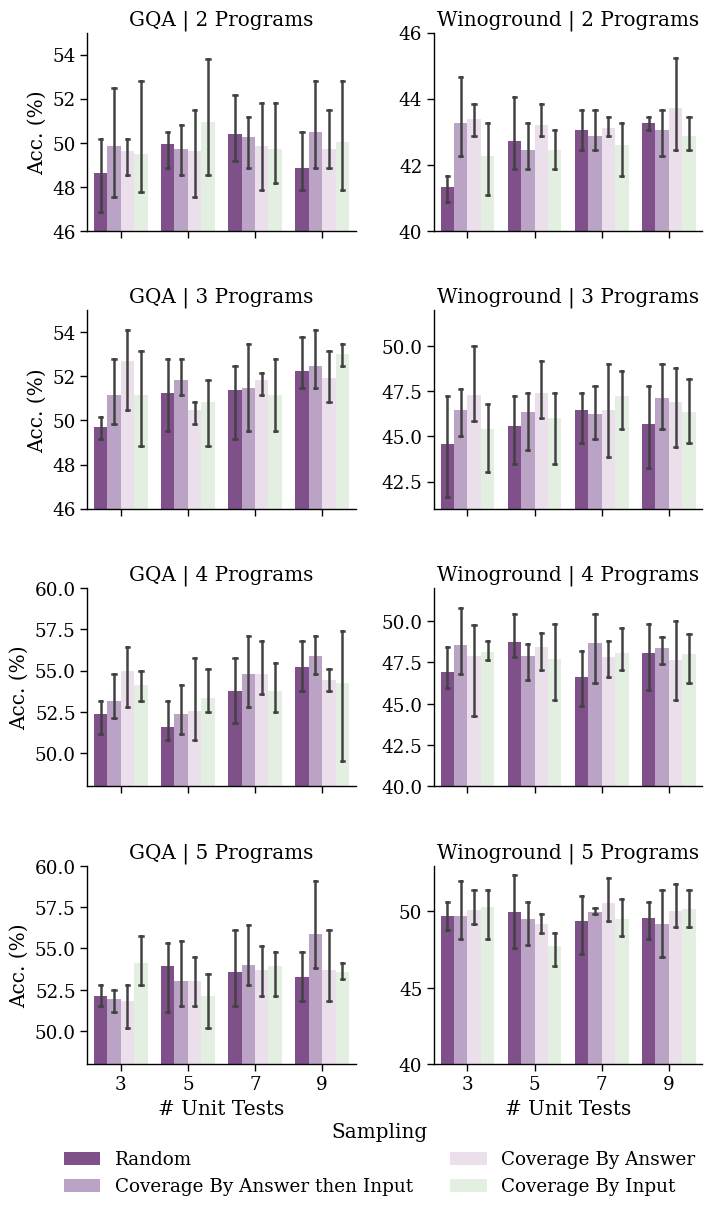

In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] =30
sampling_gqa['Dataset'] = 'GQA'
sampling_wg['Dataset'] = 'Winoground'
sampling_both = pd.concat([sampling_gqa, sampling_wg])
sampling_both = sampling_both[sampling_both['num_unit_test'] != 1]
g = sns.FacetGrid(sampling_both, col="Dataset", row='num_programs', sharey=False,  aspect=1.3)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", "sampling", palette=cmap, legend=True, capsize=0.2, dodge=True)

hues = ['Random', 'Coverage By Answer', 'Coverage By Input', 'Coverage By Answer then Input']
color_lists = [cmap[0], cmap[1], cmap[2], cmap[3], cmap[0], cmap[1], cmap[2], cmap[3]]

    
# g.axes.set_ylim(37,60)
g.axes[0,0].set_ylim(46,55)
g.axes[1,0].set_ylim(46,55)
g.axes[2,0].set_ylim(48,60)
g.axes[3,0].set_ylim(48,60)
# g.axes[0,0].fill_between([3,5,7,9], base_accuracy_gqa['acc'].mean()-base_accuracy_gqa['acc'].std(), base_accuracy_gqa['acc'].mean()+base_accuracy_gqa['acc'].std(), color='gray', alpha=0.2)
# g.axes[0,1].axhline(base_accuracy_wg['acc'].mean(), color='gray', linestyle='--', lw=3,label='Base Setup')
# g.axes[0,1].fill_between([3,5,7,9], base_accuracy_wg['acc'].mean()-base_accuracy_wg['acc'].std(), base_accuracy_wg['acc'].mean()+base_accuracy_wg['acc'].std(), color='gray', alpha=0.2)
g.axes[0,1].set_ylim(40,46)
g.axes[1,1].set_ylim(41,52)
g.axes[2,1].set_ylim(40,52)
g.axes[3,1].set_ylim(40,53)

g.set_axis_labels("# Unit Tests", "Acc. (%)")
g.set_titles("{col_name} | {row_name} Programs")
g.add_legend()
sns.move_legend(g, title='Sampling', loc='lower right', bbox_to_anchor=(0.68,-0.04), ncols=2)
plt.savefig(plot_path+'gqa_winoground_sampling_all.pdf', dpi=300, bbox_inches='tight')


## Conditioning

### GQA

In [13]:
all_data = []
for ut in [1,3,5,7,9]:
    
    # program_conditioning = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1)
    program_conditioning = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    program_conditioning['num_unit_test'] = ut
    program_conditioning['Context'] = 'Query+Program'
    all_data.append(program_conditioning)
    
    query_conditioning = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    query_conditioning['num_unit_test'] = ut
    query_conditioning['Context'] = 'Query'
    all_data.append(query_conditioning)
    
condition = pd.concat(all_data)

Error in 1
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/7_unit_test/3program/run1
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/7_unit_test/3program/run2
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/7_unit_test/3program/run3
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/7_unit_test/4program/run1
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3/diffusion_unit_tests_with_program_corr_corr/7_unit_test/4program/run2
No unit_test_results found in /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type

In [14]:
from copy import copy
def unit_test_score_penalyze_error(selected_unit_tests, unit_test_results, compilation_error_penalty=0.0, runtime_error_penalty=0.0, acc_fn=GQA_accuracy, postproc_fn=gqa_postproc):
    scores = defaultdict(int)
    def get_penalty(error):
        if error is None:
            return 0
        elif 'execute_command' in error.lower():
            return compilation_error_penalty
        else:
            return runtime_error_penalty
        
    # print(len(unit_test_results[0]))
    selected_unit_tests_org = copy(selected_unit_tests)
    for code_index in range(len(unit_test_results[0])):
        # print(code_index)
        curr_res = unit_test_results[0][code_index]['results']
        # print(unit_test_results[0][code_index]['results'])
        if isinstance(selected_unit_tests, dict):
            selected_unit_tests = selected_unit_tests_org[0][code_index]
        # print(len(curr_res))
        try:
            for t in range(len(curr_res)):
                # try:
                # scores[code_index] = 0 .
                ut = curr_res[t]['results'][0]
                # print(ut)
                # print(ut)
                if acc_fn([ut['output']], [postproc_fn(selected_unit_tests[t][1])])!=ut['acc']:
                    # print(len(curr_res))
                    # print(len(selected_unit_tests))
                    # print("Code Index", code_index)
                    # print("Unit Test Index", t)
                    if acc_fn([ut['output']], [postproc_fn(selected_unit_tests[t][1])])!=ut['acc']:
                        # print("Code Index", code_index)
                        # print("Unit Test Index", t)
                        print("Wrong")
                        print("Pred Acc", acc_fn([ut['output']], [postproc_fn(selected_unit_tests[t][1])]))
                        print("Acc", ut['acc'])
                        print("Unit Test", selected_unit_tests[t][1])
                        print("Output", ut['output'])
                        print("")
                    # print("Pred acc ", acc_fn([ut['output']], [selected_unit_tests[t][1]]))
                    # print("Acc", ut['acc'])
                    # print(selected_unit_tests[t][1])
                    # print(postproc_fn(ut['output']))
                # scores[code_index] += (acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None or ut['error'] == 'error' else 0) -get_penalty(ut['error'])
                scores[code_index] += sum([(acc_fn([ut['output']], [selected_unit_tests[t][1]]) if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
        except:
            scores[code_index] += sum([(ut['acc'] if ut['error'] is None else 0) -get_penalty(ut['error']) for ut in curr_res[t]['results']])/len(curr_res[t]['results'])
        # print(scores)
        # print(len(curr_res))
        scores[code_index] /= len(curr_res)
    # print(scores)
    # print([curr_res['acc'] for ut in unit_test_results[0]['results']])
    max_index = max(scores, key=scores.get)
    return max_index

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


<Figure size 2000x1000 with 0 Axes>

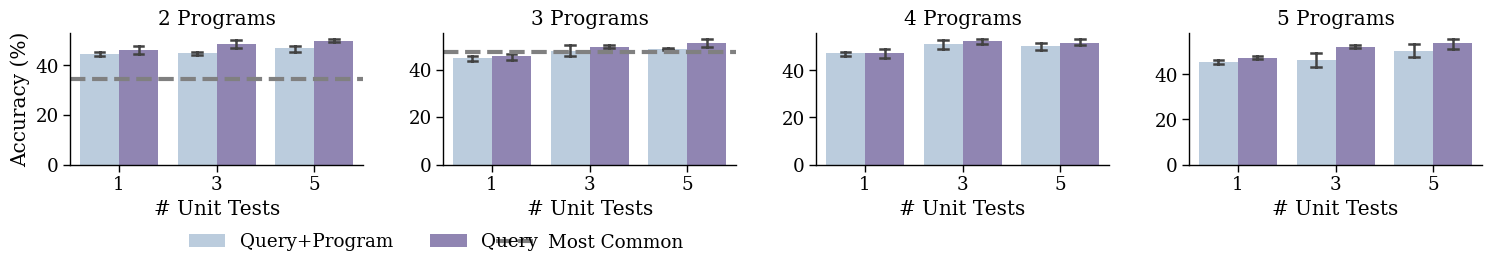

In [ ]:
df = condition
df = df[df['num_programs'].isin([2,5])]
df = df[df['num_unit_test'] <7]
# df = df[df['run'] ==3]
hue = 'Programs'
# x = 'Programs'
style = 'Context'
# style= 'Sampling'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.rcParams['font.size'] = 30
plt.figure(figsize=(20,10))

# df['hue'] = df['num_programs'].astype(str)+' '+df[style]


df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
df.rename(columns={'num_programs': 'Programs'}, inplace=True)
# Set up a FacetGrid to create separate plots for each num_programs
# g = sns.FacetGrid(df, height=4, col=col, hue=hue)
# fontsize
# plt.rc('font', size=12)          # controls default text sizes

# Add a reference line at a specific accuracy value (e.g., 55)
# reference_value =  base_data['acc'].mean()
# reference_value_std = (base_data['acc'].mean()-base_data['acc'].std()/len(base_data['acc']), base_data['acc'].mean()+base_data['acc'].std()/len(base_data['acc']))

# Create line plots in each facet and add reference line
# g.map(sns.lineplot, x, "acc", marker="o", errorbar=('ci',75), estimator=np.mean)
# g= sns.relplot(data=df, x=x, y='acc', col=col, hue=hue,style=style, kind='line', marker='o', errorbar='sd', estimator=np.mean)
               #

cmap = sns.color_palette('BuPu')

g = sns.FacetGrid(df, col='Programs', sharey=False, aspect=1.3)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", "Context", palette=[cmap[1],cmap[3]], legend=True, capsize=0.2, dodge=True)
g.axes[0,0].axhline (max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==2]['acc'].mean(), color='gray', linestyle='--', lw=3,label='Most Common Answer')
most_common_answer_std = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].std()
most_common_answer_mean = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean()
g.axes[0,1].axhline (max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean(), color='gray', linestyle='--', lw=3,label='Most Common Answer')
g.set_titles(col_template="{col_name} Programs")
g.set_axis_labels("# Unit Tests", "Accuracy (%)")
## reduce width between plots
# plt.subplots_adjust(top=0.8, wspace=0.1)
# plt.subplots_adjust(top=0.88)
# g.axes[0,0].set_ylim(33,55)
# g.axes[0,1].set_ylim(45,60)
labels = list(g._legend_data.keys())
handles = g._legend_data.values()
# handles =  list(handles) + [plt.Line2D([0], [0], color='gray', linestyle='--', lw=3,label='Base Setup')] 
# handles = [handles[0],handles[2], handles[1], handles[4], handles[3]]
# labels =  list(labels) + ['Base Setup'] 
# labels = [labels[0], labels[3], labels[1], labels[2]]
# handles = list(handles)
# handles = [handles[0], handles[3], handles[1], handles[2]]
# labels = g._legend_data.keys()
g.add_legend(handles=handles, labels=labels, ncols=2)
g.axes[0,1].legend(labels=['Most Common'], handles=[plt.Line2D([0], [0], color='gray', linestyle='--', lw=3)],frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.4))
sns.move_legend(g, loc='lower left', bbox_to_anchor=(0.12,-0.01), ncol=2, frameon=False, title=None)


# Show the plot
plt.savefig(plot_path+'gqa_program_conditioning.pdf', dpi=300, bbox_inches='tight')

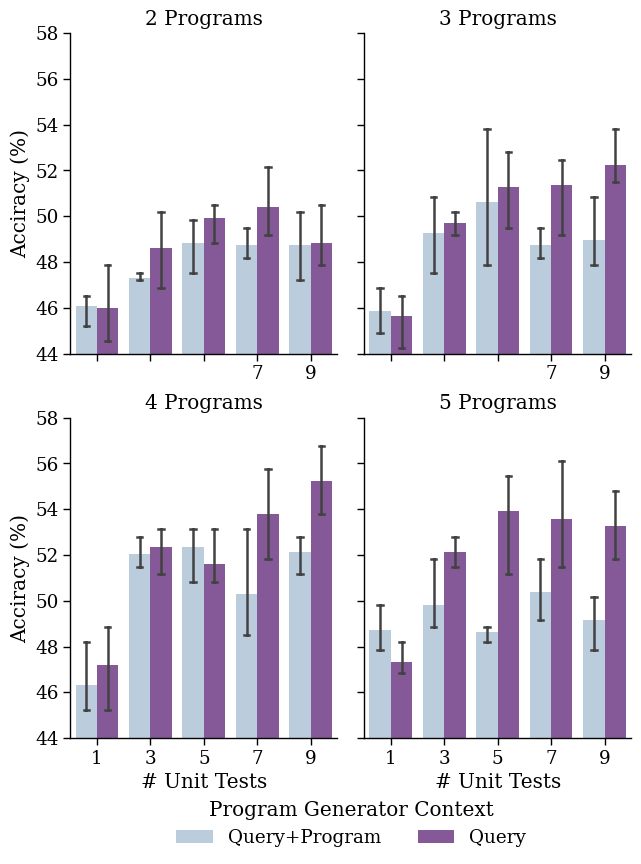

In [ ]:
df = condition
hue = 'Programs'
# x = 'Programs'
style = 'Context'
# style= 'Sampling'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] =80
plt.rcParams['figure.figsize'] = [10, 10]
# df['hue'] = df['num_programs'].astype(str)+' '+df[style]


df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
df.rename(columns={'num_programs': 'Programs'}, inplace=True)
# Set up a FacetGrid to create separate plots for each num_programs
# g = sns.FacetGrid(df, height=4, col=col, hue=hue)
# fontsize
# plt.rc('font', size=12)          # controls default text sizes

# Add a reference line at a specific accuracy value (e.g., 55)
# reference_value =  base_data['acc'].mean()
# reference_value_std = (base_data['acc'].mean()-base_data['acc'].std()/len(base_data['acc']), base_data['acc'].mean()+base_data['acc'].std()/len(base_data['acc']))

# Create line plots in each facet and add reference line
# g.map(sns.lineplot, x, "acc", marker="o", errorbar=('ci',75), estimator=np.mean)
# g= sns.relplot(data=df, x=x, y='acc', col=col, hue=hue,style=style, kind='line', marker='o', errorbar='sd', estimator=np.mean)
               #

cmap = sns.color_palette('BuPu')
               
g = sns.catplot(data=df, 
                x='num_unit_test',
                y='acc',
                # hue='Programs',
                hue=style,
                kind='bar',
                col='Programs',
                estimator=np.mean,
                col_wrap=2,
                aspect=0.8, 
                palette=[cmap[1], cmap[4]],
                # palette=[cmap[1], cmap[1],cmap[2], cmap[2],cmap[3], cmap[3],cmap[4], cmap[4]],
                legend=True,
                capsize=0.2,  # Size of the caps on error bars
                # hue_order=['2 Query', '2 Query+Program', '3 Query', '3 Query+Program', '4 Query', '4 Query+Program', '5 Query', '5 Query+Program'],
)

# hues = ['2', '3', '4', '5']
# Define hatches (patterns) for each dataset
# hatches = {'Query': '', 'Query+Program': '.'}  # 'A' gets '/', 'B' gets '\\'
# for c in range(len(g.axes.flat)):  # Iterate through each Axes in the FacetGrid
#     bars = g.axes.flat[c].patches  # Get all bars in this axes
#     # g.axes[c].set_ylim(37,60)
#     for i, bar in enumerate(bars):
#         unit_test_col = i//4
#         # bar.set_color(color_lists[unit_test_col%4])  # Set the color of the bar
#         bar.set_edgecolor('black')  # Add a black edge to the bars
#         if (i//4)%2==0:
#             bar.set_hatch(hatches['Query'])   
#         else:
#             bar.set_hatch(hatches['Query+Program'])
g.set_axis_labels("# Unit Tests", "Acciracy (%)")
# g.add_legend(title='Context', loc='lower right', bbox_to_anchor=(0.6,0.05), ncol=2)
g.set_titles("{col_name} Programs")

# g = sns.relplot(data=df, x=x, y='acc', col=col, hue=hue,kind='line', marker='o', errorbar='sd', estimator=np.mean, facet_kws={'sharey':True, 'sharex': False})  
# Set custom xticks for all the plots
# custom_xticks = [1, 3, 5, 7, 9]
# # cols = df[col].unique()
# sorted(cols)
# for idx,ax in enumerate(g.axes.flat):
#     ax.set_xticks(custom_xticks)
#     # ax.axhline(first_non_error[first_non_error[col] == idx+2]['acc'].mean(), ls='--', color='gray', label='First Non-Error')  # Add a reference line at the chosen value
#     # ax.fill_between(custom_xticks, first_non_error[first_non_error[col] == idx+2]['acc'].median()-mad(first_non_error[first_non_error[col] == idx+2]['acc']), first_non_error[first_non_error[col] == idx+2]['acc'].median()+mad(first_non_error[first_non_error[col] == idx+2]['acc']), color='gray', alpha=0.2)
#     # ax.fill_between(custom_xticks, first_non_error[first_non_error[col] == idx+2]['acc'].mean()-first_non_error[first_non_error[col] == idx+2]['acc'].std(), first_non_error[first_non_error[col] == idx+2]['acc'].mean()+first_non_error[first_non_error[col] == idx+2]['acc'].std(), color='gray', alpha=0.2)

#     ax.axhline(reference_value, ls='--', color='gray', label='Base Setup')  # Add a reference line at the chosen value
#     ax.fill_between(custom_xticks, reference_value_std[0], reference_value_std[1], color='gray', alpha=0.2)
    # ax.axhline(upper_bound_accuracy_gqa[upper_bound_accuracy_gqa[col] == cols[idx]]['acc'].mean(), ls='--', color='black', label='Upper Bound')  # Add a reference line at the chosen value
    # ax.fill_between(custom_xticks, upper_bound_accuracy_gqa[upper_bound_accuracy_gqa[col] == cols[idx]]['acc'].mean()-upper_bound_accuracy_gqa[upper_bound_accuracy_gqa[col] == cols[idx]]['acc'].std(), upper_bound_accuracy_gqa[upper_bound_accuracy_gqa[col] == cols[idx]]['acc'].mean()+upper_bound_accuracy_gqa[upper_bound_accuracy_gqa[col] == cols[idx]]['acc'].std(), color='black', alpha=0.2)
# Add titles and adjust layout
# g.set_titles(col_template="")
# g.set_axis_labels("Number of Programs", "Accuracy (%)")
plt.subplots_adjust(top=0.88, wspace=0.1, hspace=0.2)
g.set(ylim=(44,58))
# sns.move_legend(g, "right", bbox_to_anchor=(0.65,.7), ncols=1, alignment='center', fontsize='small')
# g.add_legend()
# g.fig.suptitle("GQA Accuracy for Different Program Conditioning", ha='center', x=.4)
sns.move_legend(g, title='Program Generator Context', loc='lower center', bbox_to_anchor=(0.5,0.05), ncols=2)
# g.fig.suptitle("Accuracy vs Number of Unit Tests for Different Sampling Methods")

# Show the plot
plt.savefig(plot_path+'gqa_program_conditioning_all.pdf', dpi=300, bbox_inches='tight')

## Images

### GQA

In [35]:
all_data = []

for t in tqdm(reverse_dict_gqa.keys()):
    for ut in [1,3,5,7,9]:
        unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'group': t})
        unit_test_accuracy_gqa['num_unit_test'] = ut
        unit_test_accuracy_gqa['diffusion_model'] = 'SDXL3'
        unit_test_accuracy_gqa['type'] = t
        all_data.append(unit_test_accuracy_gqa)
    diffusion = pd.concat(all_data)

    for ut in [1,3,5,7,9]:
        unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_lm_guided_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'group': t})
        unit_test_accuracy_gqa['num_unit_test'] = ut
        unit_test_accuracy_gqa['diffusion_model'] = 'LM Guided'
        unit_test_accuracy_gqa['type'] = t
        all_data.append(unit_test_accuracy_gqa)
    diffusion = pd.concat(all_data)

    for ut in [1,3,5,7,9]:
        unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_1.4_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'group': t})
        unit_test_accuracy_gqa['num_unit_test'] = ut
        unit_test_accuracy_gqa['diffusion_model'] = 'SD v1.4'
        unit_test_accuracy_gqa['type'] = t
        all_data.append(unit_test_accuracy_gqa)
    diffusion_type = pd.concat(all_data)

  1%|          | 1/102 [00:06<10:50,  6.44s/it]

100%|██████████| 102/102 [11:03<00:00,  6.50s/it]


In [ ]:
all_data = []

for ut in [1,3,5,7,9]:
    unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_gqa['num_unit_test'] = ut
    unit_test_accuracy_gqa['diffusion_model'] = 'SDXL3'
    all_data.append(unit_test_accuracy_gqa)
diffusion = pd.concat(all_data)

for ut in [1,3,5,7,9]:
    unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_lm_guided_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_gqa['num_unit_test'] = ut
    unit_test_accuracy_gqa['diffusion_model'] = 'LM Guided'
    all_data.append(unit_test_accuracy_gqa)
diffusion = pd.concat(all_data)

for ut in [1,3,5,7,9]:
    unit_test_accuracy_gqa = get_folder_accuracy(f'results/GQA/eval/sample_per_type_3/stable_diffusion_unit_tests_1.4_corr/{ut}_unit_test/'+'{}program/run{}',  compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_gqa['num_unit_test'] = ut
    unit_test_accuracy_gqa['diffusion_model'] = 'SD v1.4'
    all_data.append(unit_test_accuracy_gqa)
diffusion = pd.concat(all_data)

In [ ]:
df = diffusion_type
df = df.replace({'type': reverse_dict_gqa})
# df = df[df['diffusion_model'] != 'SD v1.4']
col = 'num_programs'
x = 'num_unit_test'
hue = 'diffusion_model'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [4, 10]
df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
g = sns.catplot(data=df, x=x, y='acc', row='type', col=col, hue=hue, kind='bar',errorbar='sd',estimator=np.mean)#, facet_kws={'sharey': True, 'sharex': False})


# Set custom xticks for all the plots
custom_xticks = [1, 2,3,4,5,6,7,8,9]
g.set_titles(col_template="Number of Programs: {col_name}")
g.set_axis_labels("Number of Unit Tests", "Accuracy (%)")
plt.subplots_adjust(top=0.85)
sns.move_legend(g, "lower center", bbox_to_anchor=(0.4,-0.1),ncol=6, title='Diffusion Model')
plt.savefig(plot_path+'gqa_diffusion_models.pdf', dpi=300, bbox_inches='tight')

### WinoGround

In [34]:
### PLOT UNIT TEST ACCURACY GQA LM Guided ## 
all_data = []
for t in reverse_dict_wg.keys():
    for ut in [1,3,5,7,9]:
        unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag': t})
        unit_test_accuracy_wg['num_unit_test'] = ut
        unit_test_accuracy_wg['diffusion_model'] = 'SDXL3'
        unit_test_accuracy_wg['type'] = t
        all_data.append(unit_test_accuracy_wg)
    diffusion_wg = pd.concat(all_data)

    for ut in [1,3,5,7,9]:
        unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_lm_guided/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag': t})
        unit_test_accuracy_wg['num_unit_test'] = ut
        unit_test_accuracy_wg['diffusion_model'] = 'LM Guided'
        unit_test_accuracy_wg['type'] = t
        all_data.append(unit_test_accuracy_wg)
    diffusion_wg = pd.concat(all_data)

    for ut in [1,3,5,7,9]:
        unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_sdv1.4/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0, filter={'tag': t})
        unit_test_accuracy_wg['num_unit_test'] = ut
        unit_test_accuracy_wg['diffusion_model'] = 'SD v1.4'
        unit_test_accuracy_wg['type'] = t
        all_data.append(unit_test_accuracy_wg)
    diffusion_wg_type = pd.concat(all_data)


In [269]:
for ut in [1,3,5,7,9]:
    unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_high_temp/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_wg['num_unit_test'] = ut
    unit_test_accuracy_wg['diffusion_model'] = 'SDXL3'
    all_data.append(unit_test_accuracy_wg)
diffusion_wg = pd.concat(all_data)

for ut in [1,3,5,7,9]:
    unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_lm_guided/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_wg['num_unit_test'] = ut
    unit_test_accuracy_wg['diffusion_model'] = 'LM Guided'
    all_data.append(unit_test_accuracy_wg)
diffusion_wg = pd.concat(all_data)

for ut in [1,3,5,7,9]:
    unit_test_accuracy_wg = get_folder_accuracy(f'/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/sample_per_type_3/stable_diffusion_unit_tests_sdv1.4/{ut}_unit_test/'+'{}program/run{}',compute='penalyze_error', compile_error_penalty=0.0, runtime_error_penalty=0.0)
    unit_test_accuracy_wg['num_unit_test'] = ut
    unit_test_accuracy_wg['diffusion_model'] = 'SD v1.4'
    all_data.append(unit_test_accuracy_wg)
diffusion_wg = pd.concat(all_data)


In [ ]:
df = diffusion_wg
# df = df[df['diffusion_model'] != 'SD v1.4']
col = 'num_programs'
x = 'num_unit_test'
hue = 'diffusion_model'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [4, 10]
df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
# Set up a FacetGrid to create separate plots for each num_programs
# g = sns.FacetGrid(df, height=4, col=col, hue=hue, sharex=False, sharey=False)
# fontsize
# plt.rc('font', size=12)          # controls default text sizes

# Add a reference line at a specific accuracy value (e.g., 55)
# reference_value =  base_data['acc'].mean()
# reference_value_std = st.t.interval(0.90, len(base_data['acc']), reference_value, st.sem(base_data['acc']))
g = sns.relplot(data=df, x=x, y='acc', col=col, hue=hue, col_wrap=2, kind='line', marker='o', errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), estimator=np.median, facet_kws={'sharey': True, 'sharex': False}, palette='Dark2', aspect=1.3)

# Set custom xticks for all the plots
custom_xticks = [1, 3, 5, 7, 9]

g.set_titles(col_template="Number of Programs: {col_name}")
g.set_axis_labels("Number of Unit Tests", "Accuracy (%)")
plt.subplots_adjust(top=0.85)
sns.move_legend(g, "lower center", bbox_to_anchor=(0.4,-0.1),ncol=6, title='Diffusion Model')
# plt.legend(title='Diffusion Method', loc='lower right', bbox_to_anchor=(0.,-0.45), ncols=10)
# g.fig.suptitle("Accuracy vs Number of Unit Tests for Different Image ")

# Show the plot
# plt.show()
plt.savefig(plot_path+'wg_diffusion_models.pdf', dpi=300, bbox_inches='tight')

### Combine

In [ ]:
diffusion['Dataset'] = 'GQA'
diffusion_wg['Dataset'] = 'WinoGround'
df = pd.concat([diffusion, diffusion_wg])
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] =30
plt.rcParams['figure.figsize'] = [8, 4]

# df['hue'] = df['diffusion_model'] + ' ' + df['Dataset']
df = df[df['num_programs'] == 5]
df['Diffusion Model'] = df['diffusion_model']

cmap = sns.color_palette('PiYG')
color_list = [cmap[1], cmap[0], cmap[2], cmap[1], cmap[0], cmap[2],]
g= sns.FacetGrid(df, col='Dataset', height=4, aspect=1.2, palette=color_list, sharey=False)
g.map(sns.barplot, 'num_unit_test', 'acc', 'Diffusion Model', capsize=0.2, dodge=True, legend=True, hue_order=['SDXL3', 'LM Guided', 'SD v1.4'], palette=color_list)

g.axes[0,0].axhline (max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean(), color='gray', linestyle='--', lw=3,label='Most Common Answer')
most_common_answer_std = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].std()
most_common_answer_mean = max_count_accuracy_gqa[max_count_accuracy_gqa['num_programs']==5]['acc'].mean()
# g.axes[0,0].fill_between([0,1,2,3],most_common_answer_mean-most_common_answer_std, most_common_answer_mean+most_common_answer_std, color='gray', alpha=0.2)
g.axes[0,0].set_ylim(45,60)
g.axes[0,1].set_ylim(41,55)
most_common_answer_wg = max_count_accuracy_wg[max_count_accuracy_wg['num_programs']==5]['acc'].mean()
g.axes[0,1].axhline (most_common_answer_wg, color='gray', linestyle='--', lw=3,label='Most Common Answer')
most_common_answer_std_wg = max_count_accuracy_wg[max_count_accuracy_wg['num_programs']==5]['acc'].std()
g.set_axis_labels("# Unit Tests", "Accuracy (%)")
g.set_titles("{col_name}")
labels = list(g._legend_data.keys())
handles = g._legend_data.values()
# handles =  list(handles) + [plt.Line2D([0], [0], color='gray', linestyle='--', lw=3,label='Base Setup')] 
# handles = [handles[0],handles[2], handles[1], handles[4], handles[3]]
# labels =  list(labels) + ['Base Setup'] 
# labels = [labels[0], labels[3], labels[1], labels[2]]
# handles = list(handles)
# handles = [handles[0], handles[3], handles[1], handles[2]]
# labels = g._legend_data.keys()
g.add_legend(handles=handles, labels=labels, title='Sampling', ncols=1)
g.axes[0,1].legend(labels=['Most Common'], handles=[plt.Line2D([0], [0], color='gray', linestyle='--', lw=3)],frameon=False, loc='upper center', bbox_to_anchor=(0.5,-0.23))
sns.move_legend(g, loc='lower left', bbox_to_anchor=(0.12,-0.01), ncol=3, frameon=False, title=None)

plt.savefig(plot_path+'gqa_winoground_diffusion_acc.pdf', dpi=300, bbox_inches='tight')

/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


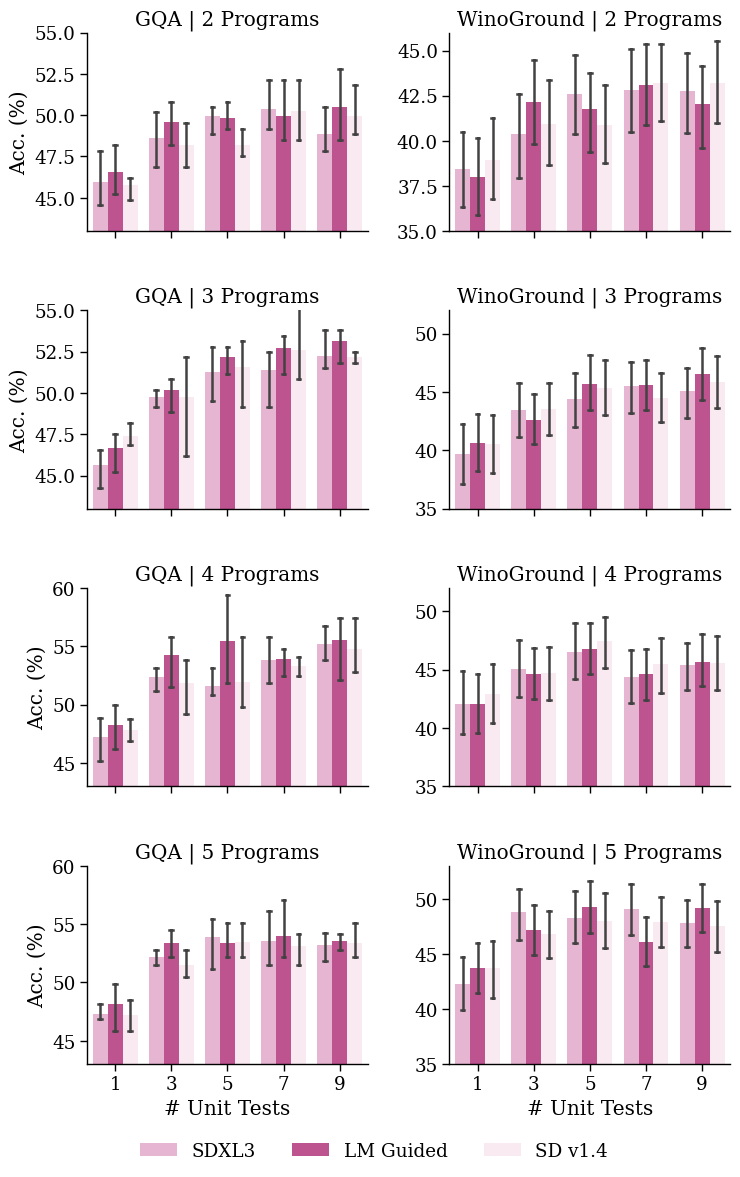

In [284]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] =30
diffusion['Dataset'] = 'GQA'
diffusion_wg['Dataset'] = 'WinoGround'
df = pd.concat([diffusion, diffusion_wg])
cmap = sns.color_palette('PiYG')
cmap = [cmap[1], cmap[0], cmap[2]]
g = sns.FacetGrid(df, col="Dataset", row='num_programs', sharey=False,  aspect=1.3)  # Explicitly setting sharey=False
g.map(sns.barplot, "num_unit_test", "acc", "diffusion_model", palette=cmap, legend=True, capsize=0.2, dodge=True)
    
# g.axes.set_ylim(37,60)
g.axes[0,0].set_ylim(43,55)
g.axes[1,0].set_ylim(43,55)
g.axes[2,0].set_ylim(43,60)
g.axes[3,0].set_ylim(43,60)
# g.axes[0,0].fill_between([3,5,7,9], base_accuracy_gqa['acc'].mean()-base_accuracy_gqa['acc'].std(), base_accuracy_gqa['acc'].mean()+base_accuracy_gqa['acc'].std(), color='gray', alpha=0.2)
# g.axes[0,1].axhline(base_accuracy_wg['acc'].mean(), color='gray', linestyle='--', lw=3,label='Base Setup')
# g.axes[0,1].fill_between([3,5,7,9], base_accuracy_wg['acc'].mean()-base_accuracy_wg['acc'].std(), base_accuracy_wg['acc'].mean()+base_accuracy_wg['acc'].std(), color='gray', alpha=0.2)
g.axes[0,1].set_ylim(35,46)
g.axes[1,1].set_ylim(35,52)
g.axes[2,1].set_ylim(35,52)
g.axes[3,1].set_ylim(35,53)

g.set_axis_labels("# Unit Tests", "Acc. (%)")
g.set_titles("{col_name} | {row_name} Programs")
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(0.7,-0.01), ncols=3)
plt.savefig(plot_path+'gqa_winoground_diffusion_all.pdf', dpi=300, bbox_inches='tight')


/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/nlp/data/artemisp/miniforge3/envs/viunit_env/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


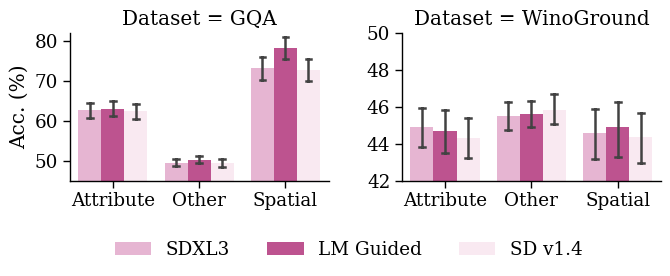

In [44]:
gqa = diffusion_type.copy()
gqa['Dataset'] = 'GQA'
wg = diffusion_wg_type.copy()
wg['Dataset'] = 'WinoGround'
# wg.replace(reverse_dict_wg, inplace=True)
# gqa.replace(reverse_dict_gqa, inplace=True)
wg['type'] = wg['type'].apply(map_wg)
gqa['type'] = gqa['type'].apply(map_gqa)

df = pd.concat([gqa,wg])
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 25
plt.rcParams['figure.figsize'] = [6, 8]

# df = df[df['num_unit_test'] > ]
# df = df[df['num_programs'] > 2]
cmap = sns.color_palette('PiYG')
cmap = [cmap[1], cmap[0], cmap[2]]
# df = df[df['type'].isin(['Attribute','Spatial',  'Category'])]
# df = df[df['type'].isin(list(reversed_items.keys())[80:])]
sorted_data = df.sort_values(by="acc", ascending=False)

# df = df[df['num_programs'] == 5]
df =df[df['num_unit_test'] > 1] 
# df = df[df['type'].isin(existAttr_groups)]
col = 'num_programs' 
x = 'num_unit_test'
hue = 'diffusion_model'
df = df
df = df.astype({'num_programs': 'int', 'num_unit_test': 'int', 'run': 'int'}, copy=False)
g = sns.FacetGrid(df, col="Dataset", sharey=False,  aspect=1.2)  # Explicitly setting sharey=False
g.map(sns.barplot, "type", "acc", hue, palette=cmap, legend=True, capsize=0.2, dodge=True)

g.set_axis_labels("", "Acc. (%)")
g.axes[0,0].set_ylim(45,82)
g.axes[0,1].set_ylim(42,50)
# g.axes[1,1].set_ylim(40,55)
# g.axes[2,1].set_ylim(40,55)
# g.axes[3,1].set_ylim(40,53)

# set ylimits
g.add_legend()
# g.set(ylim=(40,70))
sns.move_legend(g, loc='lower right', bbox_to_anchor=(0.73,-0.01), ncols=3)
# g.fig.suptitle("GQA Accuracy for Different Sampling Methods")

# Show the plot
plt.savefig(plot_path+'gqa_wg_diffusion_cateogires.pdf', dpi=300, bbox_inches='tight')

# Train

In [90]:

from accuracy_fns import GQA_accuracy, general_accuracy, okvqa_accuracy
def load_train_eval(folder, compute='no_error', i_=1, run2iter=None):
    data ={'num_programs': [], 'acc': [], 'run': [], 'iteration': [], 'num_unit_tests': [], 'acc_type': [], 'percentage_errors': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    for i in [i_]:
        for s in [1,2,3]: #range(1,1):
            if os.path.exists(folder.format(i,s)) and os.path.exists(folder.format(i,s)+'/data.p'):
                with open(folder.format(i,s)+'/data.p', 'rb') as f:
                    data_train = pickle.load(f)
                    for iter in [0,1,2,3,4,5,6,7,8,9]:
                        if run2iter and run2iter[s]== iter+1:
                            break
                        if iter in data_train[0]['code_execution_results']:
                            if compute == 'no_error':
                                acc =  sum([acc_fn([d['code_execution_results'][iter][0]['output']], [d['answer']]) if d['code_execution_results'][iter][0]['error'] is None else 0 for d in data_train])/len(data_train)
                            else:
                                acc = sum([acc_fn([d['code_execution_results'][iter][0]['output']], [d['answer']]) for d in data_train])/len(data_train)
                        else:
                            print('No accuracy found in {}'.format(folder.format(i,s)) + ' train iter {}'.format(iter))
                            break
                        num_errors = sum([1 if d['code_execution_results'][iter][0]['error'] is not None else 0 for d in data_train])
                        data['percentage_errors'].append(num_errors/len(data_train))
                        data['acc'].append(acc*100.)#.append(float(acc_line[0].split(':')[-1])*100.)
                        # data['acc'].append(float(acc_line[0].split(':')[-1])*100.)
                        data['acc_type'].append('Train')
                        data['num_programs'].append(i)
                        data['run'].append(s)
                        data['iteration'].append(iter+1)
                        if 'base_execution' in folder:
                            data['num_unit_tests'].append('ViRep')
                        else:
                            if 'ut' in folder:
                                data['num_unit_tests'].append('ViRep + ' + folder.split('ut_')[0].split('/')[-1] + ' Unit Tests')
                            else:
                                data['num_unit_tests'].append('ViRep + ' + folder.split('_unit_test')[0].split('/')[-1] + ' Unit Tests')
            else:
                print('Folder {} does not exist'.format(folder.format(i,s)))

            for iter in [0,1,2,3,4,5,6,7,8,9]:
                if run2iter and run2iter[s]== iter+1:
                            break
                if os.path.exists(folder.format(i,s) + f'/eval_virep/{iter}') and os.path.exists(folder.format(i,s)+ f'/eval_virep/{iter}'+'/log.txt'):
                    with open(folder.format(i,s)+ f'/eval_virep/{iter}'+'/log.txt', 'r') as file:
                        acc_line = [line for line in file.readlines()[::-1] if 'accuracy' in line.lower()]
                        if len(acc_line) == 0:
                            print('No accuracy found in {}'.format(folder.format(i,s)) + ' val iter {}'.format(iter))
                        else:
                            with open(folder.format(i,s)+ f'/eval_virep/{iter}'+'/data.p', 'rb') as file:
                                data_ = pickle.load(file)
                                if 'output' not in data_[0]:
                                    print('No output in {}'.format(folder.format(i,s)) + ' val iter {}'.format(iter))
                                    continue
                                if compute == 'no_error':
                                    acc =  sum([acc_fn([d['output']['output']], [d['answer']]) if d['output']['error'] is None else 0 for d in data_])/len(data_)
                                else:
                                    acc = sum([acc_fn([d['output']['output']], [d['answer']]) for d in data_])/len(data_)
                                num_errors = sum([1 if d['output']['error'] is not None else 0 for d in data_])
                                data['percentage_errors'].append(num_errors/len(data_))
                                data['acc'].append(acc*100.)#.append(float(acc_line[0].split(':')[-1])*100.)
                                # data['acc'].append(float(acc_line[0].split(':')[-1])*100.)
                                data['acc_type'].append('Validation')
                                data['num_programs'].append(i)
                                data['run'].append(s)
                                data['iteration'].append(iter+1)
                                if 'base_execution' in folder:
                                    data['num_unit_tests'].append('ViRep')
                                else:
                                    if 'ut' in folder:
                                        data['num_unit_tests'].append('ViRep + ' + folder.split('ut_')[0].split('/')[-1] + ' Unit Tests')
                                    else:
                                        data['num_unit_tests'].append('ViRep + ' + folder.split('_unit_test')[0].split('/')[-1] + ' Unit Tests')
                else:
                    print('Folder {} does not exist'.format(folder.format(i,s)+f'/eval_virep/{iter}'))        
    return pd.DataFrame(data)


def load_train_eval_wg(folder, eval_folder='eval', compute='no_error', run2iter=None):
    data ={'num_programs': [], 'acc': [], 'run': [], 'iteration': [], 'num_unit_tests': [], 'acc_type': [], 'percentage_errors': []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else general_accuracy
    if 'okvqa' in eval_folder.lower():
        acc_fn = okvqa_accuracy
    for i in [1]:
        for s in [1,2,3]: #range(1,1):
            if os.path.exists(folder.format(i,s)) and os.path.exists(folder.format(i,s)+'/data.p'):
                with open(folder.format(i,s)+'/data.p', 'rb') as f:
                    data_train = pickle.load(f)
                    for iter in [0,1,2,3,4,5,6,7,8,9]:
                        if run2iter and run2iter[s]== iter+1:
                            break
                        if iter in data_train[0]['code_execution_results']:
                            if compute == 'no_error':
                                acc = sum([acc_fn([d['code_execution_results'][iter][0]['output']], [d['answer']]) if d['code_execution_results'][iter][0]['error'] is None else 0 for d in data_train])/len(data_train)
                            else:
                                acc = sum([acc_fn([d['code_execution_results'][iter][0]['output']], [d['answer']]) for d in data_train])/len(data_train)
                        else:
                            print('No accuracy found in {}'.format(folder.format(i,s)) + ' train iter {}'.format(iter))
                            break
                        data['percentage_errors'].append(sum([1 if d['code_execution_results'][iter][0]['error'] is not None else 0 for d in data_train])/len(data_train))
                        data['acc'].append(acc*100.)#.append(float(acc_line[0].split(':')[-1])*100.)
                        # data['acc'].append(float(acc_line[0].split(':')[-1])*100.)
                        data['acc_type'].append('Train')
                        data['num_programs'].append(i)
                        data['run'].append(s)
                        data['iteration'].append(iter+1)
                        if 'base_execution' in folder:
                            data['num_unit_tests'].append('ViRep')
                        else:
                            if 'ut' in folder:
                                data['num_unit_tests'].append('ViRep + ' + folder.split('ut_')[0].split('/')[-1] + ' Unit Tests')
                            else:
                                data['num_unit_tests'].append('ViRep + ' + folder.split('_unit_test')[0].split('/')[-1] + ' Unit Tests')
            else:
                print('Folder {} does not exist'.format(folder.format(i,s)))
                
            for iter in [0,1,2,3,4,5,6,7,8,9]:
                if run2iter and run2iter[s]== iter+1:
                            break
                if os.path.exists(folder.format(i,s) + f'/{eval_folder}/{iter}') and os.path.exists(folder.format(i,s)+ f'/{eval_folder}/{iter}'+'/log.txt'):
                    with open(folder.format(i,s)+ f'/{eval_folder}/{iter}'+'/log.txt', 'r') as file:
                        acc_line = [line for line in file.readlines()[::-1] if 'accuracy' in line.lower()]
                        if len(acc_line) == 0:
                            print('No accuracy found in {}'.format(folder.format(i,s)) + ' val iter {}'.format(iter))
                        else:
                            with open(folder.format(i,s)+ f'/{eval_folder}/{iter}'+'/data.p', 'rb') as file:
                                data_ = pickle.load(file)
                                if 'output' not in data_[0]:
                                    print('No output in {}'.format(folder.format(i,s)) + ' val iter {}'.format(iter))
                                else:
                                    if compute == 'no_error':
                                        acc =  sum([acc_fn([d['output']['output']], [d['answer']]) if d['output']['error'] is None else 0 for d in data_])/len(data_)
                                    else:
                                        acc = sum([acc_fn([d['output']['output']], [d['answer']]) for d in data_])/len(data_)
                                        
                                    data['percentage_errors'].append(sum([1 if d['output']['error'] is not None else 0 for d in data_])/len(data_))
                                    data['acc'].append(acc*100.)#.append(float(acc_line[0].split(':')[-1])*100.)
                                    # data['acc'].append(float(acc_line[0].split(':')[-1])*100.)
                                    data['acc_type'].append('Validation')
                                    data['num_programs'].append(i)
                                    data['run'].append(s)
                                    data['iteration'].append(iter+1)
                                    if 'base_execution' in folder:
                                        data['num_unit_tests'].append('ViRep')
                                    else:
                                        if 'ut' in folder:
                                            data['num_unit_tests'].append('ViRep + ' + folder.split('ut_')[0].split('/')[-1] + ' Unit Tests')
                                        else:
                                            data['num_unit_tests'].append('ViRep + ' + folder.split('_unit_test')[0].split('/')[-1] + ' Unit Tests')
                else:
                    print('Folder {} does not exist'.format(folder.format(i,s)+f'/{eval_folder}/{iter}'))
                    
    return pd.DataFrame(data)

def get_base_train_accuracy(folder, compute='no_error'):
    data ={'num_programs': [], 'acc': [], 'run': [], 'iteration': [], 'num_unit_tests': [], 'acc_type': [], "percentage_errors": []}
    acc_fn = GQA_accuracy if 'gqa' in folder.lower() else okvqa_accuracy if 'okvqa' in folder.lower() else general_accuracy

    for i in [1]:
        for s in [1,2,3]: #range(1,1):
            # for iter in [0,1,2,3,4,5,6,7,8,9,10,11,12,13]:
            if True:
                if os.path.exists(folder.format(i,s)) and os.path.exists(folder.format(i,s)+'/log.txt'):
                    with open(folder.format(i,s)+'/log.txt', 'r') as file:
                        acc_line = [line for line in file.readlines()[::-1] if 'accuracy' in line.lower()]
                        if len(acc_line) == 0:
                            print('No accuracy found in {}'.format(folder.format(i,s)) + ' eval iter {}'.format(iter))
                        if True:
                            with open(folder.format(i,s)+'/data.p', 'rb') as file:
                                data_ = pickle.load(file)
                                # if 'output' not in data_[0]:
                                #     continue
                                if compute == 'no_error':
                                    acc = sum([acc_fn([d['code_outputs'][0][0]['output']],[d['answer']]) if d['code_outputs'][0][0]['error'] is None else 0 for d in data_])/len(data_)
                                else:
                                    acc = sum([acc_fn([d['code_outputs'][0][0]['output']],[d['answer']]) for d in data_])/len(data_)
                                    
                                data['percentage_errors'].append(sum([1 if d['code_outputs'][0][0]['error'] is not None else 0 for d in data_])/len(data_))
                                data['acc'].append(acc*100.)#.append(float(acc_line[0].split(':')[-1])*100.)
                                # data['acc'].append(float(acc_line[0].split(':')[-1])*100.)
                                data['acc_type'].append('Validation')
                                data['num_programs'].append(i)
                                data['run'].append(s)
                                data['iteration'].append(0)
                                if 'base_execution' in folder:
                                    data['num_unit_tests'].append('ViRep')
                                else:
                                    if 'ut' in folder:
                                        data['num_unit_tests'].append('ViRep + ' + folder.split('ut_')[0].split('/')[-1] + ' Unit Tests')
                                    else:
                                        data['num_unit_tests'].append('ViRep + ' + folder.split('_unit_test')[0].split('/')[-1] + ' Unit Tests')
                else:
                    print('Folder {} does not exist'.format(folder.format(i,s)))

    return pd.DataFrame(data)

### GQA

In [54]:
# training new ut to check replicability
data = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error')
data_ut = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error')
# data = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}'))
# data_ut = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}'))

data_wg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', eval_folder='eval_wg')
data_ut_wg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error', eval_folder='eval_wg')


data_sc = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', eval_folder='eval_sc')
data_ut_sc = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error', eval_folder='eval_sc')

data_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', eval_folder='eval_vqa')
data_ut_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error', eval_folder='eval_vqa')

data_okvqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', eval_folder='eval_okvqa')
data_ut_okvqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='no_error', eval_folder='eval_okvqa')


data_fixed = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='fixed_code')
data_ut_fixed = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", compute='fixed_code')


base_data = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/')
base_data_fixed = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/virep_split/base_execution/{}program/run{}/', compute='fixed_code')


base_data = base_data[base_data['num_programs'] == 1]
base_data['acc_type'] = 'Validation'
base_data['Dataset'] = 'GQA'
base_data['Model'] = 'CodeLLaMA'
base_data['iteration'] = 0
base_data['num_unit_tests'] =  'Correctness Reward'
data['num_unit_tests'] = 'Correctness Reward'
data = pd.concat((data, base_data.copy()))
base_data['num_unit_tests'] = 'ViUnit Reward'
data_ut['num_unit_tests'] = 'ViUnit Reward'
data_ut = pd.concat((data_ut, base_data.copy()))
data['Dataset'] = 'GQA'
data['Model'] = 'CodeLLaMA'
data_ut['Dataset'] = 'GQA'
data_ut['Model'] = 'CodeLLaMA'
data_ut['num_unit_tests'] ='ViUnit Reward'


base_data_fixed = base_data[base_data_fixed['num_programs'] == 1]
base_data_fixed['acc_type'] = 'Validation'
base_data_fixed['Dataset'] = 'GQA'
base_data_fixed['Model'] = 'CodeLLaMA'
base_data_fixed['iteration'] = 0
base_data_fixed['num_unit_tests'] =  'Correctness Reward'
base_data_fixed['num_unit_tests'] = 'Correctness Reward'
data_fixed = pd.concat((data_fixed, base_data_fixed.copy()))
base_data_fixed['num_unit_tests'] = 'ViUnit Reward'
data_ut_fixed['num_unit_tests'] = 'ViUnit Reward'
data_ut_fixed = pd.concat((data_ut_fixed, base_data_fixed.copy()))
data_fixed['Dataset'] = 'GQA'
data_fixed['Model'] = 'CodeLLaMA'
data_ut_fixed['Dataset'] = 'GQA'
data_ut_fixed['Model'] = 'CodeLLaMA'
data_ut_fixed['num_unit_tests'] ='ViUnit Reward'

Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/0 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/1 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/2 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/3 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/4 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1program/run1/eval_wg/6 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/1pr

In [95]:
data_okvqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', eval_folder='eval_okvqa')
data_ut_okvqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", compute='no_error', eval_folder='eval_okvqa')



Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/0 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/1 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/2 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/3 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/4 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/5 does not exist
Folder /nlpgpu/data/artemisp/visua

In [97]:
data_okvqa[data_okvqa['acc_type'] == 'Validation']['acc'].mean(), data_okvqa[data_okvqa['acc_type'] == 'Validation']['acc'].std()

(28.121212121212125, 6.196062021397364)

In [11]:
data_cg = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}")
data_ut_cg = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}")
# data_cg = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}'))
# data_ut_cg = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}'))


data_sc_cg =  load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", eval_folder='eval_sc')
data_ut_sc_cg =  load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", eval_folder='eval_sc')

data_sc_wg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", eval_folder='eval_wg')
data_ut_sc_wg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", eval_folder='eval_wg')

data_sc_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", eval_folder='eval_vqa')
data_ut_sc_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", eval_folder='eval_vqa')

data_cg_fixed = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", compute='fixed_code')
data_ut_cg_fixed = load_train_eval("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", compute='fixed_code')



base_data = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/')
base_data_fixed = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/virep_split/base_execution/{}program/run{}/', compute='fixed_code')





base_data = base_data[base_data['num_programs'] == 1]
base_data['acc_type'] = 'Validation'
base_data['Dataset'] = 'GQA'
base_data['Model'] = 'CodeGemma'
base_data['iteration'] = 0
base_data['num_unit_tests'] = 'Correctness Reward'
data_cg['num_unit_tests'] = 'Correctness Reward'
data_cg['Dataset'] = 'GQA'
data_cg['Model'] = 'CodeGemma'
data_ut_cg['Dataset'] = 'GQA'
data_ut_cg['Model'] = 'CodeGemma'
data_ut_cg['num_unit_tests'] = 'ViUnit Reward'
data_cg = pd.concat((data_cg, base_data.copy()))
base_data['num_unit_tests'] = 'ViUnit Reward'
data_ut_cg = pd.concat((data_ut_cg, base_data.copy()))


base_data_fixed = base_data_fixed[base_data_fixed['num_programs'] == 1]
base_data_fixed['acc_type'] = 'Validation'
base_data_fixed['Dataset'] = 'GQA'
base_data_fixed['Model'] = 'CodeGemma'
base_data_fixed['iteration'] = 0
base_data_fixed['num_unit_tests'] = 'Correctness Reward'
data_cg_fixed['num_unit_tests'] = 'Correctness Reward'
data_cg_fixed['Dataset'] = 'GQA'
data_cg_fixed['Model'] = 'CodeGemma'
data_ut_cg_fixed['Dataset'] = 'GQA'
data_ut_cg_fixed['Model'] = 'CodeGemma'
data_ut_cg_fixed['num_unit_tests'] = 'ViUnit Reward'
data_cg_fixed = pd.concat((data_cg_fixed, base_data_fixed.copy()))
base_data_fixed['num_unit_tests'] = 'ViUnit Reward'
data_ut_cg_fixed = pd.concat((data_ut_cg_fixed, base_data_fixed.copy()))
data_cg_fixed['num_unit_tests'] = 'ViUnit Reward'
data_cg_fixed['Dataset'] = 'GQA'
data_cg_fixed['Model'] = 'CodeGemma'

Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/0 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/1 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/2 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/3 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/4 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_sc/5 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/res

In [52]:
data_sc_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}", eval_folder='eval_okvqa')
data_ut_sc_vqa = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", eval_folder='eval_okvqa')


Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/0 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/1 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/2 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/3 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/4 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/1program/run1/eval_okvqa/5 does not exist
Folder /nlpgpu/data/artemisp/visua

### SC

In [ ]:
data_sc = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}")
data_sc_ut = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}")


# data_sc = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}", run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}'))
# data_sc_ut = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}'))

data_sc_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}", compute='fixed_code')
data_sc_ut_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", compute='fixed_code')

data_base_sc = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/')
data_base_sc_fixed = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/base_execution_high_temp_special_prompts/{}program/run{}/', compute='fixed_code')

data_sc['Dataset'] = 'SugarCREPE'
data_sc['Model'] = 'CodeLLaMA'
data_sc_ut['Dataset'] = 'SugarCREPE'
data_sc_ut['Model'] = 'CodeLLaMA'
data_sc['num_unit_tests'] ='Correctness Reward'
data_base_sc['acc_type'] = 'Validation'
data_base_sc['Dataset'] = 'SugarCREPE'
data_base_sc['Model'] = 'CodeLLaMA'
data_base_sc['iteration'] = 0
data_base_sc['num_unit_tests'] = 'Correctness Reward'
data_sc = pd.concat((data_sc, data_base_sc.copy()))
data_base_sc['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut = pd.concat((data_sc_ut, data_base_sc.copy()))

data_sc_fixed['Dataset'] = 'SugarCREPE'
data_sc_fixed['Model'] = 'CodeLLaMA'
data_sc_ut_fixed['Dataset'] = 'SugarCREPE'
data_sc_ut_fixed['Model'] = 'CodeLLaMA'
data_sc_fixed['num_unit_tests'] ='Correctness Reward'
data_base_sc_fixed['acc_type'] = 'Validation'
data_base_sc_fixed['Dataset'] = 'SugarCREPE'
data_base_sc_fixed['Model'] = 'CodeLLaMA'
data_base_sc_fixed['iteration'] = 0
data_base_sc_fixed['num_unit_tests'] = 'Correctness Reward'
data_sc_fixed = pd.concat((data_sc_fixed, data_base_sc_fixed.copy()))
data_base_sc_fixed['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut_fixed['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut_fixed = pd.concat((data_sc_ut_fixed, data_base_sc_fixed.copy()))





data_wg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}", eval_folder='eval_wg')
data_wg_ut = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", eval_folder='eval_wg')

data_wg_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}", eval_folder='eval_wg', compute='fixed_code')
data_wg_ut_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", eval_folder='eval_wg', compute='fixed_code')

data_wg['Dataset'] = 'WinoGround'
data_wg['Model'] = 'CodeLLaMA'
data_wg_ut['Dataset'] = 'WinoGround'
data_wg_ut['Model'] = 'CodeLLaMA'

data_wg_fixed['Dataset'] = 'WinoGround'
data_wg_fixed['Model'] = 'CodeLLaMA'
data_wg_ut_fixed['Dataset'] = 'WinoGround'
data_wg_ut_fixed['Model'] = 'CodeLLaMA'


Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1/eval_wg/2 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1/eval_wg/3 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1/eval_wg/4 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1/eval_wg/5 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1/eval_wg/6 does not exist
Folder /nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/1program/run1

In [ ]:
# data_sc_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}")
# data_sc_ut_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}",eval_folder='eval')

data_sc_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}", compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}'))
data_sc_ut_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}",eval_folder='eval', compute='no_error', run2iter=get_stop_iteration_for_folder('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}'))

data_sc_cg_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}", compute='fixed_code')
data_sc_ut_cg_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}",eval_folder='eval', compute='fixed_code')
# data_sc_ut_cg = data_sc_ut_cg[data_sc_ut_cg['run'] != 3]
data_sc_cg['Dataset'] = 'SugarCREPE'
data_sc_cg['Model'] = 'CodeGemma'
data_sc_ut_cg['Dataset'] = 'SugarCREPE'
data_sc_ut_cg['Model'] = 'CodeGemma'
data_sc_ut_cg['num_unit_tests'] = 'ViUnit Reward'
data_base_sc_cg = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/')
data_base_sc_cg['acc_type'] = 'Validation'
data_base_sc_cg['Dataset'] = 'SugarCREPE'
data_base_sc_cg['Model'] = 'CodeGemma'
data_base_sc_cg['iteration'] = 0
data_base_sc_cg['num_unit_tests'] = 'Correctness Reward'
data_sc_cg['num_unit_tests'] = 'Correctness Reward'
data_sc_cg = pd.concat((data_sc_cg, data_base_sc_cg.copy()))
data_base_sc_cg['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut_cg = pd.concat((data_sc_ut_cg, data_base_sc_cg.copy()))

data_sc_cg_fixed['Dataset'] = 'SugarCREPE'
data_sc_cg_fixed['Model'] = 'CodeGemma'
data_sc_ut_cg_fixed['Dataset'] = 'SugarCREPE'
data_sc_ut_cg_fixed['Model'] = 'CodeGemma'
data_sc_ut_cg_fixed['num_unit_tests'] = 'ViUnit Reward'
data_base_sc_cg_fixed = get_base_train_accuracy('/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/base_execution_high_temp/{}program/run{}/', compute='fixed_code')
data_base_sc_cg_fixed['acc_type'] = 'Validation'
data_base_sc_cg_fixed['Dataset'] = 'SugarCREPE'
data_base_sc_cg_fixed['Model'] = 'CodeGemma'
data_base_sc_cg_fixed['iteration'] = 0
data_base_sc_cg_fixed['num_unit_tests'] = 'Correctness Reward'
data_sc_cg_fixed['num_unit_tests'] = 'Correctness Reward'
data_sc_cg_fixed = pd.concat((data_sc_cg_fixed, data_base_sc_cg_fixed.copy()))
data_base_sc_cg_fixed['num_unit_tests'] = 'ViUnit Reward'
data_sc_ut_cg_fixed = pd.concat((data_sc_ut_cg_fixed, data_base_sc_cg_fixed.copy()))


data_wg_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}", eval_folder='eval_wg')
data_wg_ut_cg = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", eval_folder='eval_wg')

data_wg_cg_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}", eval_folder='eval_wg')
data_wg_ut_cg_fixed = load_train_eval_wg("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", eval_folder='eval_wg')

data_wg_cg['Dataset'] = 'WinoGround'
data_wg_cg['Model'] = 'CodeGemma'
data_wg_ut_cg['Dataset'] = 'WinoGround'
data_wg_ut_cg['Model'] = 'CodeGemma'

data_wg_cg_fixed['Dataset'] = 'WinoGround'
data_wg_cg_fixed['Model'] = 'CodeGemma'
data_wg_ut_cg_fixed['Dataset'] = 'WinoGround'
data_wg_ut_cg_fixed['Model'] = 'CodeGemma'

{1: [0.41243654822335024, 0.43274111675126903, 0.44923857868020306, 0.4590736040609137, 0.4649746192893401, 0.4642554991539763, 0.46646120377084843, 0.46875, 0.4671460800902425, 0.46573604060913704], 2: [0.41624365482233505, 0.43781725888324874, 0.45219966159052455, 0.46573604060913704, 0.47081218274111675, 0.4756768189509306, 0.4767947788252357, 0.475253807106599, 0.47377326565143824, 0.4696700507614213], 3: [0.40482233502538073, 0.440989847715736, 0.461082910321489, 0.4746192893401015, 0.4796954314720812, 0.48286802030456855, 0.4844089920232052, 0.48413705583756345, 0.48251551043429214, 0.4788071065989848]}
{1: 5, 2: 7, 3: 7}
{1: [0.4086294416243655, 0.4251269035532995, 0.4335871404399323, 0.44289340101522845, 0.4578680203045685, 0.46150592216582065, 0.4650108774474257, 0.4646256345177665, 0.46728708403835306, 0.4697969543147208], 2: [0.4149746192893401, 0.4403553299492386, 0.45346869712351945, 0.4527284263959391, 0.4583756345177665, 0.46383248730964466, 0.46736765772298766, 0.469860

### Plot

In [ ]:
## concat datasets
train_data = pd.concat([data, data_ut, data_cg, data_ut_cg,  data_sc, data_sc_ut, data_sc_cg, data_sc_ut_cg])

train_data_fixed = pd.concat([data_fixed, data_ut_fixed, data_cg_fixed, data_ut_cg_fixed,  data_sc_fixed, data_sc_ut_fixed, data_sc_cg_fixed, data_sc_ut_cg_fixed])
# train_data = pd.concat([data_sc, data_sc_ut, data_sc_cg, data_sc_ut_cg])

NameError: name 'data_sc_cg' is not defined

/tmp/ipykernel_10584/2479154125.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('ViUnit Reward', 'ViUniT Reward', inplace=True)


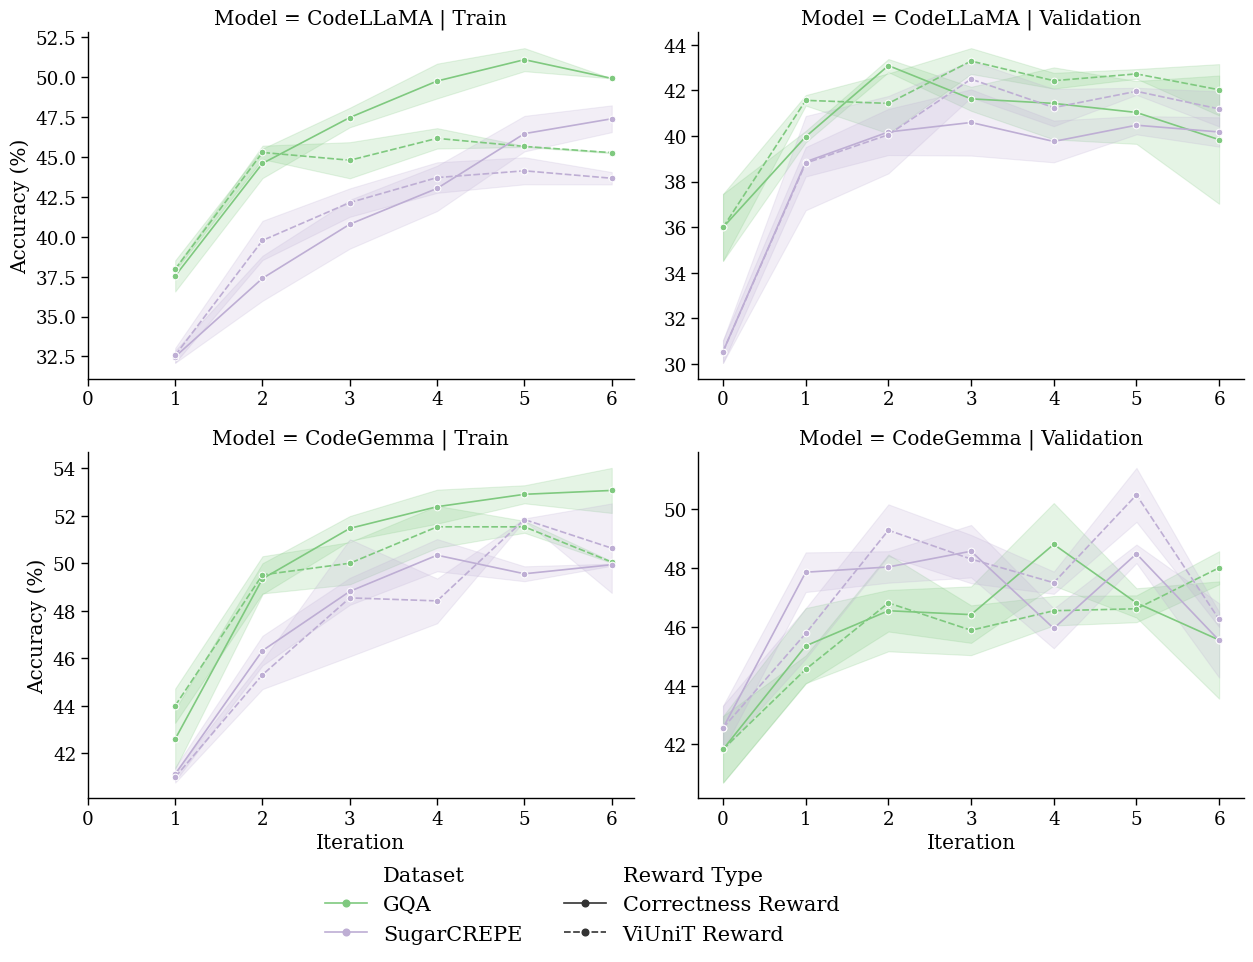

In [ ]:
df = train_data
x = 'iteration'
hue = 'Reward Type' #'num_unit_tests'
col = 'acc_type'
row = 'Model'
style='Dataset'
# style= 'Sampling'
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 40
plt.rcParams['figure.figsize'] = [8,4]

# df = df[df['Model'] == 'CodeLLaMA']
# # df = df[df['Dataset'] == 'GQA']
df  = df[df['iteration']<7]
# df = df[df['run'] == 3]
# df
df.replace('ViUnit Reward', 'ViUniT Reward', inplace=True)

df = df.astype({'num_programs': 'int', 'run': 'int'}, copy=False)
# Set up a FacetGrid to create separate plots for each num_programs
df.rename(columns={'num_programs': 'Programs', 'num_unit_tests': 'Reward Type'}, inplace=True)
# g = sns.FacetGrid(df, height=4, col=col, hue=hue,  sharex=False, sharey=False)
# fontsize
# plt.rc('font', size=12)          # controls default text sizes


# Add a reference line at a specific accuracy value (e.g., 55)

# Create line plots in each facet and add reference line
# g.map(sns.lineplot, x, "acc", errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), estimator=np.median)
# g = sns.relplot(data=df, x=x, y='acc', col=col, hue=style, style=hue, kind='line', marker='o', errorbar='sd', estimator=np.mean, aspect=1.3, palette='Dark2', facet_kws={'sharey': False, 'sharex': False})

# 
g = sns.relplot(data=df, x=x, y='acc', col=col, hue=style, row=row, style=hue, kind='line', marker='o', errorbar=('sd',0.5), estimator=np.mean, aspect=1.3, palette='Accent' , facet_kws={'sharey': False, 'sharex': False})

# g = sns.relplot(data=df, x=x, y='acc', col=col, hue=style, row=row, style=hue, kind='line', marker='o', errorbar=lambda x: (x.median()-mad(x), x.median()+mad(x)), estimator=np.median, aspect=1.3, palette='Dark2', facet_kws={'sharey': False, 'sharex': False})
# custom_xticks = [1,2,3,4,5,6,7,8,9,10]
custom_xticks = [0,1,2,3,4,5,6] #,8,9,10]

# reference_value =  base_data['acc'].mean()
# reference_value_std = st.t.interval(0.75, len(base_data['acc']), reference_value, st.sem(base_data['acc']))
# g.axes.flat[0].axhline(reference_value, ls='--', color='gray', label='Base Setup')  # Add a reference line at the chosen value
# # g.axes.flat[0].fill_between(custom_xticks, reference_value_std[0], reference_value_std[1], color='gray', alpha=0.2)
# g.axes.flat[0].set_xticks(custom_xticks)
# g.axes.flat[1].set_xticks(custom_xticks)

# cols = df[col].unique()
# sorted(cols)
# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Iteration", "Accuracy (%)")
plt.subplots_adjust(top=0.85)
# set axes every 1 
for ax in g.axes.flat:
    ax.set_xticks(custom_xticks)
sns.move_legend(g, loc='lower center', bbox_to_anchor=(0.4,-0.08), ncols=2, fontsize=15)
# g.fig.suptitle("Accuracy vs Number of Unit Tests for Different Sampling Methods")

# Show the plot
# plt.show()
plt.savefig(plot_path+'train_eval_accuracy.pdf', dpi=300, bbox_inches='tight')

In [10]:
def get_rewards_base(folder):
    run2reward = {}
    for i in [1]:
        for s in [1,2,3]:
            all_rewards = []
            if os.path.exists(folder.format(i,s)+'/data.p'):
                data = pickle.load(open(folder.format(i,s)+'/data.p', 'rb'))
                iteration_rewards = []
                for iter in range(10):
                    for d in data:
                        iteration_rewards.append(d['code_execution_results'][iter][0]['acc'] if d['code_execution_results'][iter][0]['error'] is None else 0)
                    all_rewards.append(sum(iteration_rewards)/len(iteration_rewards))
                run2reward[s] = all_rewards
    return run2reward

def get_rewards_ut(folder):
    run2reward = {}
    for i in [1]:
        for s in [1,2,3]:
            all_rewards = []
            if os.path.exists(folder.format(i,s)+'/data.p'):
                data = pickle.load(open(folder.format(i,s)+'/data.p', 'rb'))
                iteration_rewards = []
                for iter in range(10):
                    for d in data:
                        if iter not in d['unit_test_results']:
                            continue
                        unit_test_accuracy  = d['unit_test_results'][iter][0]['acc']
                        reward = max(unit_test_accuracy, int(unit_test_accuracy >= 0.8))                      
                        iteration_rewards.append(reward)
                    all_rewards.append(sum(iteration_rewards)/len(iteration_rewards))
                run2reward[s] = all_rewards
    return run2reward
            

In [11]:
def early_stopping(reward_history, decline_limit=1):
    """
    Determines whether to stop training early based on consecutive performance declines.

    Parameters:
    - reward_history: List of rewards from previous episodes or epochs.
    - decline_limit: Number of consecutive declines allowed before stopping.

    Returns:
    - stop: Boolean indicating whether to stop training.
    """
    if len(reward_history) < decline_limit + 1:
        # Not enough data to decide, continue training
        return False

    # Check if the last episodes show consecutive declines
    decline_count = 0
    for i in range(1, decline_limit + 1):
        if reward_history[-i] < reward_history[-i - 1]:
            decline_count += 1
        else:
            # Reset count if any improvement is seen
            decline_count = 0
            break

    # Stop if declines have reached the specified limit
    return decline_count == decline_limit

def get_stop_iteration_for_folder(folder, ut=False, decline_limit=1, min_iter=0):
    if ut:
        run2reward = get_rewards_ut(folder)
    else:
        run2reward = get_rewards_base(folder)
    print(run2reward)
    
    stop_iterations = {}
    for run in run2reward:
        rewards = run2reward[run]
        stop_iterations[run] = []
        for i in range(min_iter+decline_limit,len(rewards)):
            if early_stopping(rewards[:i], decline_limit):
                stop_iterations[run] = i-decline_limit
                break
            if i == len(rewards)-1:
                stop_iterations[run] = i+1
    # for k,v in stop_iterations.items():
    #     stop_iterations[k]+=1
    print(stop_iterations)
    return stop_iterations
    
        

In [54]:
# training new ut to check replicability
gqa_base_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/base_execution_new_new/{}program/run{}")
gqa_ut_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train/sample_per_type_10/unit_tests_new/5ut_threshold_ratio_new_new_new/{}program/run{}", ut=True)

{1: [0.3796477495107632, 0.41487279843444225, 0.43933463796477495, 0.46012720156555775, 0.47338551859099803, 0.47504892367906065, 0.47246295778585407, 0.46978962818003916, 0.46771037181996084, 0.46585127201565557], 2: [0.3542074363992172, 0.38992172211350296, 0.41682974559686886, 0.43395303326810175, 0.44677103718199607, 0.4554794520547945, 0.45946323734973443, 0.45878180039138944, 0.4537943031093716, 0.45019569471624266], 3: [0.3923679060665362, 0.42710371819960863, 0.43966079582517936, 0.4508317025440313, 0.46223091976516634, 0.4683626875407697, 0.47134470226446745, 0.4739481409001957, 0.4780387040661013, 0.48170254403131113]}
{1: 6, 2: 7, 3: 10}
{1: [0.3688845401174159, 0.40068493150685186, 0.4131767775603437, 0.4208904109589092, 0.42414872798434766, 0.4251793868232191, 0.4262230919765082, 0.4277641878669149, 0.42789736899324343, 0.42737769080233057], 2: [0.3665362035225034, 0.396868884540119, 0.40658838878017356, 0.4134050880626268, 0.41679060665362344, 0.41709067188518967, 0.41671

In [55]:
sc_base_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/base_execution_high_temp_new_new/{}program/run{}")
sc_ut_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_correct_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", ut=True)

{1: [0.3197969543147208, 0.3553299492385787, 0.3739424703891709, 0.3902284263959391, 0.40482233502538073, 0.41328257191201356, 0.41950688905003625, 0.42496827411167515, 0.42865200225606315, 0.4315989847715736], 2: [0.33375634517766495, 0.33756345177664976, 0.350253807106599, 0.3623096446700508, 0.3784263959390863, 0.39678510998307953, 0.4108049311094996, 0.42163705583756345, 0.4276649746192893, 0.43477157360406093], 3: [0.3210659898477157, 0.3553299492385787, 0.3824027072758037, 0.40006345177664976, 0.41751269035532995, 0.42745346869712353, 0.43636693255982595, 0.44194162436548223, 0.4478285391990976, 0.449492385786802]}
{1: 10, 2: 10, 3: 10}
{1: [0.4162436548223344, 0.46649746192893576, 0.4962774957698851, 0.5203680203045705, 0.5341116751269044, 0.545304568527916, 0.5548948513415461, 0.5617703045685202, 0.5647772137619761, 0.5684517766497382], 2: [0.409137055837563, 0.41852791878172707, 0.4346869712351977, 0.4495558375634536, 0.46426395939086396, 0.475507614213196, 0.4854242204495951,

In [56]:
# gqa_base_run2iter = get_iteration_with_training_performance_drop(data)
# gqa_ut_run2iter = get_iteration_with_training_performance_drop(data_ut)
# sc_base_run2iter = get_iteration_with_training_performance_drop(data_sc)
# sc_ut_run2iter = get_iteration_with_training_performance_drop(data_sc_ut)
# gqa_base_run2iter, gqa_ut_run2iter, sc_base_run2iter, sc_ut_run2iter

In [12]:
def get_iteration_with_training_performance_drop(df):
    df_train = df[df['acc_type'] == 'Train']
    df_val = df[df['acc_type'] == 'Validation']
    run2iter = {}
    for s in [1,2,3]:
        accuracies = []
        for iter in range(1,11):
            acc = df_train[(df_train['run'] == s) & (df_train['iteration'] == iter)]['acc']
            if len(acc.values) == 0:
                continue
            if len(accuracies)>2:
                if acc.values[0] < accuracies[-1] and accuracies[-1]<accuracies[-2]:
                    run2iter[s] = iter-2
                    break
            if len(acc.values) == 0:
                break
            accuracies.append(acc.values[0])
            if iter == 10:
                if acc.values[0] < accuracies[-1]:
                    run2iter[s] = 9
                else:
                    run2iter[s] = 10
    print(run2iter)
    try:
        performance=[df_val[(df['run'] == s) & (df_val['iteration'] == run2iter[s])]['acc'].values[0] if len(df_val[(df['run'] == s) & (df_val['iteration'] == run2iter[s])]['acc'].values) > 0 else -1 for s in [1,2,3]]
    except:
        performance = [-1,-1,-1]
    return np.array(performance)

In [13]:
def get_df_acc(df, run2iter={1:10, 2:10, 3:10}):
    print(run2iter)
    df_train = df[df['acc_type'] == 'Train']
    df_val = df[df['acc_type'] == 'Validation']
    performance = []
    for s in [1,2,3]:
        acc = df_val[(df_val['run'] == s) & (df_val['iteration'] == run2iter[s])]['acc']
        if len(acc.values) == 0:
            performance.append(-1)
        else:
            performance.append(acc.values[0])
    # performance=[df_val[(df['run'] == s) & (df['iteration'] == run2iter[s])]['acc'].values[0] if len(df_val[(df['run'] == s) & (df['iteration'] == run2iter[s])]['acc'].values) > 0 else -1 for s in [1,2,3]]
    print(performance)
    return np.array([p for p in performance if p != -1])

def get_df_error(df, run2iter={1:10, 2:10, 3:10}):
    print(run2iter)
    df_train = df[df['acc_type'] == 'Train']
    df_val = df[df['acc_type'] == 'Validation']
    performance = []
    for s in [1,2,3]:
        acc = df_val[(df_val['run'] == s) & (df_val['iteration'] == run2iter[s])]['percentage_errors']
        if len(acc.values) == 0:
            performance.append(-1)
        else:
            performance.append(acc.values[0])
    # performance=[df_val[(df['run'] == s) & (df['iteration'] == run2iter[s])]['acc'].values[0] if len(df_val[(df['run'] == s) & (df['iteration'] == run2iter[s])]['acc'].values) > 0 else -1 for s in [1,2,3]]
    print(performance)
    return np.array([p*100 for p in performance if p != -1])

In [309]:
template = 'Open LLM + RL (Correctness Reward)& CodeLlama-7B & 1 & 0 &{}&{}&{}&{}&{} &{}& {}&{}\\'
template_fixed = 'Open LLM + RL (Correctness Reward)& CodeLlama-7B\\textdagger & 1 & 0 &{}&{}&{}&{}&{}&{} & {}&{}\\'
single_template = "{:.2f}$\pm${:.2f}"
gqa_base_acc = get_df_acc(data, gqa_base_run2iter)
gqa_base_err = get_df_error(data, gqa_base_run2iter)
gqa_ut_acc = get_df_acc(data_ut, gqa_ut_run2iter)
gqa_ut_err = get_df_error(data_ut, gqa_ut_run2iter)


gqa_base_wg_acc = get_df_acc(data_wg, gqa_base_run2iter)
gqa_base_wg_err = get_df_error(data_wg, gqa_base_run2iter)
gqa_ut_wg_acc = get_df_acc(data_ut_wg, gqa_ut_run2iter)
gqa_ut_wg_err = get_df_error(data_ut_wg, gqa_ut_run2iter)

gqa_base_sc_acc = get_df_acc(data_sc, gqa_base_run2iter)
gqa_base_sc_err = get_df_error(data_sc, gqa_base_run2iter)
gqa_ut_sc_acc = get_df_acc(data_ut_sc, gqa_ut_run2iter)
gqa_ut_sc_err = get_df_error(data_ut_sc, gqa_ut_run2iter)

gqa_base_vqa_acc = get_df_acc(data_vqa, gqa_base_run2iter)
gqa_base_vqa_err = get_df_error(data_vqa, gqa_base_run2iter)
gqa_ut_vqa_acc = get_df_acc(data_ut_vqa, gqa_ut_run2iter)
gqa_ut_vqa_err = get_df_error(data_ut_vqa, gqa_ut_run2iter)

print("VQA", gqa_base_vqa_acc.mean(), gqa_base_vqa_acc.std(), gqa_ut_vqa_acc.mean(), gqa_ut_vqa_acc.std())



print("WG", gqa_base_wg_acc.mean(), gqa_base_wg_acc.std(), gqa_ut_wg_acc.mean(), gqa_ut_wg_acc.std())
print("SC", gqa_base_sc_acc.mean(), gqa_base_sc_acc.std(), gqa_ut_sc_acc.mean(), gqa_ut_sc_acc.std())

sc_base_acc = get_df_acc(data_sc, sc_base_run2iter)
sc_base_err = get_df_error(data_sc, sc_base_run2iter)
sc_ut_acc = get_df_acc(data_ut_sc, sc_ut_run2iter)
sc_ut_err = get_df_error(data_ut_sc, sc_ut_run2iter)

gqa_base_acc_fixed = get_df_acc(data_fixed, gqa_base_run2iter)
gqa_ut_acc_fixed = get_df_acc(data_ut_fixed, gqa_ut_run2iter)
sc_base_acc_fixed = get_df_acc(data_sc_fixed, sc_base_run2iter)
sc_ut_acc_fixed = get_df_acc(data_sc_ut_fixed, sc_ut_run2iter)

# gqa_base_acc = get_iteration_with_training_performance_drop(data)
# gqa_ut_acc = get_iteration_with_training_performance_drop(data_ut)
# sc_base_acc = get_iteration_with_training_performance_drop(data_sc)
# sc_ut_acc = get_iteration_with_training_performance_drop(data_sc_ut)
wg_base_acc =get_df_acc(data_wg, sc_base_run2iter)
wg_base_err =get_df_error(data_wg, sc_base_run2iter)
wg_ut_acc =get_df_acc(data_wg_ut, sc_ut_run2iter)
wg_ut_err =get_df_error(data_wg_ut, sc_ut_run2iter)

wg_base_acc_fixed =get_df_acc(data_wg_fixed, sc_base_run2iter)
wg_ut_acc_fixed =get_df_acc(data_wg_ut_fixed, sc_ut_run2iter)


avg_base = np.mean([gqa_base_acc.mean(), wg_base_acc.mean(), sc_base_acc.mean()])
avg_base_std = np.mean([gqa_base_acc.std(), wg_base_acc.std(), sc_base_acc.std()])
avg_base_err = np.mean([gqa_base_err.mean(), wg_base_err.mean(), sc_base_err.mean()])
avg_base_err_std = np.mean([gqa_base_err.std(), wg_base_err.std(), sc_base_err.std()])
avg_ut = np.mean([gqa_ut_acc.mean(), wg_ut_acc.mean(), sc_ut_acc.mean()])
avg_ut_std = np.mean([gqa_ut_acc.std(), wg_ut_acc.std(), sc_ut_acc.std()])
avg_ut_err = np.mean([gqa_ut_err.mean(), wg_ut_err.mean(), sc_ut_err.mean()])
avg_ut_err_std = np.mean([gqa_ut_err.std(), wg_ut_err.std(), sc_ut_err.std()])

avg_base_fixed = np.mean([gqa_base_acc_fixed.mean(), wg_base_acc_fixed.mean(), sc_base_acc_fixed.mean()])
avg_base_fixed_std = np.mean([gqa_base_acc_fixed.std(), wg_base_acc_fixed.std(), sc_base_acc_fixed.std()])
avg_ut_fixed = np.mean([gqa_ut_acc_fixed.mean(), wg_ut_acc_fixed.mean(), sc_ut_acc_fixed.mean()])
avg_ut_fixed_std = np.mean([gqa_ut_acc_fixed.std(), wg_ut_acc_fixed.std(), sc_ut_acc_fixed.std()])

print(template.format(
    single_template.format(gqa_base_acc.mean(), gqa_base_acc.std()),
    single_template.format(gqa_base_err.mean(), gqa_base_err.std()),
    single_template.format(wg_base_acc.mean(), wg_base_acc.std()),
    single_template.format(wg_base_err.mean(), wg_base_err.std()),
    single_template.format(sc_base_acc.mean(), sc_base_acc.std()),
    single_template.format(sc_base_err.mean(), sc_base_err.std()),
    single_template.format(avg_base, avg_base_std),
    single_template.format(avg_base_err, avg_base_err_std),
))


{1: 6, 2: 7, 3: 10}
[39.04382470119522, 33.266932270916335, 45.21912350597609]
{1: 6, 2: 7, 3: 10}
[0.15737051792828685, 0.24302788844621515, 0.053784860557768925]
{1: 10, 2: 6, 3: 8}
[38.44621513944223, 39.8406374501992, 43.42629482071713]
{1: 10, 2: 6, 3: 8}
[0.10756972111553785, 0.11354581673306773, 0.06573705179282868]
{1: 6, 2: 7, 3: 10}
[40.625, 37.5, 44.9375]
{1: 6, 2: 7, 3: 10}
[0.23, 0.3175, 0.126875]
{1: 10, 2: 6, 3: 8}
[44.625, 39.6875, 46.5625]
{1: 10, 2: 6, 3: 8}
[0.174375, 0.195625, 0.109375]
{1: 6, 2: 7, 3: 10}
[30.892857142857146, 34.464285714285715, 46.07142857142857]
{1: 6, 2: 7, 3: 10}
[0.325, 0.36607142857142855, 0.18214285714285713]
{1: 10, 2: 6, 3: 8}
[40.89285714285714, 43.57142857142857, 48.57142857142857]
{1: 10, 2: 6, 3: 8}
[0.21071428571428572, 0.225, 0.10535714285714286]
{1: 6, 2: 7, 3: 10}
[34.2, 25.8, 43.0]
{1: 6, 2: 7, 3: 10}
[0.168, 0.33, 0.11]
{1: 10, 2: 6, 3: 8}
[37.6, 32.6, 37.4]
{1: 10, 2: 6, 3: 8}
[0.172, 0.148, 0.096]
VQA 34.333333333333336 7.02250

NameError: name 'data_sc_fixed' is not defined

In [ ]:

template_ut = 'Open LLM + RL (ViU$^2$nit Reward)& CodeLlama-7B & 1 & 0 &{}&{}&{}&{}&{}&{} & {}&{}\\'
template_ut_fixed = 'Open LLM + RL (ViU$^2$nit Reward)& CodeLlama-7B\\textdagger & 1 & 0 &{}&{}&{} & {}\\'
avg_ut = np.mean([gqa_ut_acc.mean(), wg_ut_acc.mean(), sc_ut_acc.mean()])
avg_ut_std = np.mean([gqa_ut_acc.std(), wg_ut_acc.std(), sc_ut_acc.std()])
avg_ut_fixed = np.mean([gqa_ut_acc_fixed.mean(), wg_ut_acc_fixed.mean(), sc_ut_acc_fixed.mean()])
avg_ut_fixed_std = np.mean([gqa_ut_acc_fixed.std(), wg_ut_acc_fixed.std(), sc_ut_acc_fixed.std()])
print(template_ut.format(
    single_template.format(gqa_ut_acc.mean(), gqa_ut_acc.std()),
    single_template.format(gqa_ut_err.mean(), gqa_ut_err.std()),
    single_template.format(wg_ut_acc.mean(), wg_ut_acc.std()),
    single_template.format(wg_ut_err.mean(), wg_ut_err.std()),
    single_template.format(sc_ut_acc.mean(), sc_ut_acc.std()),
    single_template.format(sc_ut_err.mean(), sc_ut_err.std()),
    single_template.format(avg_ut, avg_ut_std),
    single_template.format(avg_ut_err, avg_ut_err_std),
))


Open LLM + RL (ViU$^2$nit Reward)& CodeLlama-7B & 1 & 0 &40.57$\pm$2.10&9.56$\pm$2.13&46.52$\pm$0.81&10.31$\pm$1.55&41.85$\pm$1.44&15.42$\pm$3.03 & 42.98$\pm$1.45&11.76$\pm$2.24\


In [23]:
gqa_cg_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/base_execution_new_new/{}program/run{}")
gqa_ut_cg_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/train_codegemma/sample_per_type_10/unit_tests_new/5ut_threshold_and_correct_lm_guided_ratio_new_new_new/{}program/run{}", ut=True)
sc_cg_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/base_execution_new_new/{}program/run{}")
sc_ut_cg_run2iter = get_stop_iteration_for_folder("/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/train_codegemma/sample_per_type_10_small/stable_diffusion_unit_tests_threshold_ratio_new_new_new_new_new/1_unit_test/{}program/run{}", ut=True)

{1: [0.42367906066536204, 0.4569471624266145, 0.47227658186562294, 0.48189823874755383, 0.48962818003913894, 0.4928245270711024, 0.49594632373497344, 0.49816536203522505, 0.5013046314416177, 0.5042074363992172], 2: [0.4021526418786693, 0.44227005870841485, 0.46771037181996084, 0.4811643835616438, 0.4919765166340509, 0.5, 0.5046128040257198, 0.5100293542074364, 0.517503805175038, 0.5209393346379648], 3: [0.4520547945205479, 0.4799412915851272, 0.49412915851272016, 0.5053816046966731, 0.5105675146771037, 0.5159817351598174, 0.5195694716242661, 0.5225048923679061, 0.5248967166775386, 0.5280821917808219]}
{1: 10, 2: 10, 3: 10}
{1: [0.45009784735812075, 0.4639921722113536, 0.4672537508153994, 0.47397260273973135, 0.4792172211350285, 0.481963470319628, 0.4848196812971653, 0.4875244618395156, 0.4894107414655212, 0.4910371819960715], 2: [0.41878669275929453, 0.44510763209393645, 0.4615786040443608, 0.4709393346379689, 0.47718199608610357, 0.48153946510110146, 0.48395303326809047, 0.48590998043

In [22]:
print(gqa_cg_run2iter,gqa_ut_cg_run2iter,sc_cg_run2iter, sc_ut_cg_run2iter )

{1: 10, 2: 10, 3: 10} {1: 10, 2: 8, 3: 10} {1: 5, 2: 7, 3: 7} {1: 6, 2: 8, 3: 7}


In [26]:
template = 'Open LLM + RL (Correctness Reward)& CodeGemma-7B & 1 & 0 &{}&{}&{} &{}&{} &{}&{}&{}\\\\'
template_fixed = 'Open LLM + RL (Correctness Reward)& CodeGemma-7B\\textdagger & 1 & 0 &{}&{}&{} &{}\\\\'

# gqa_cg_base_acc = get_df_acc(data_cg, gqa_cg_run2iter)
# gqa_cg_ut_acc = get_df_acc(data_ut_cg, gqa_ut_cg_run2iter)
# sc_cg_base_acc =get_df_acc(data_sc_cg, sc_cg_run2iter)
# sc_cg_ut_acc = get_df_acc(data_sc_ut_cg, sc_ut_cg_run2iter)
# gqa_cg_base_err = get_df_error(data_cg, gqa_cg_run2iter)
# gqa_cg_ut_err = get_df_error(data_ut_cg, gqa_ut_cg_run2iter)
# sc_cg_base_err = get_df_error(data_sc_cg, sc_cg_run2iter)
# sc_cg_ut_err = get_df_error(data_sc_ut_cg, sc_ut_cg_run2iter)

wg_cg_base_acc = get_df_acc(data_sc_wg,gqa_cg_run2iter)
wg_cg_ut_acc = get_df_acc(data_ut_sc_wg,gqa_ut_cg_run2iter)
sc_cg_base_acc = get_df_acc(data_sc_cg,gqa_cg_run2iter)
sc_cg_ut_acc = get_df_acc(data_ut_sc_cg,gqa_ut_cg_run2iter)

print("WG", wg_cg_base_acc.mean(), wg_cg_base_acc.std(), wg_cg_ut_acc.mean(), wg_cg_ut_acc.std())
print("SC", sc_cg_base_acc.mean(), sc_cg_base_acc.std(), sc_cg_ut_acc.mean(), sc_cg_ut_acc.std())


# gqa_cg_base_acc_fixed = get_df_acc(data_cg_fixed, gqa_cg_run2iter)
# gqa_cg_ut_acc_fixed = get_df_acc(data_ut_cg_fixed, gqa_ut_cg_run2iter)
# sc_cg_base_acc_fixed =get_df_acc(data_sc_cg_fixed, sc_cg_run2iter)
# sc_cg_ut_acc_fixed = get_df_acc(data_sc_ut_cg_fixed, sc_ut_cg_run2iter)

# # gqa_cg_base_acc = get_iteration_with_training_performance_drop(data_cg)
# gqa_cg_ut_acc = get_iteration_with_training_performance_drop(data_ut_cg)
# sc_cg_base_acc = get_iteration_with_training_performance_drop(data_sc_cg)
# sc_cg_ut_acc = get_iteration_with_training_performance_drop(data_sc_ut_cg)
wg_cg_base_acc = get_df_acc(data_wg_cg,sc_cg_run2iter)
wg_cg_ut_acc = get_df_acc(data_wg_ut_cg,sc_ut_cg_run2iter)
sc_cg_base_acc = get_df_error(data_wg_cg,sc_cg_run2iter)
sc_cg_ut_acc = get_df_error(data_wg_ut_cg,sc_ut_cg_run2iter)

wg_cg_base_acc_fixed = get_df_acc(data_wg_cg_fixed,sc_cg_run2iter)
wg_cg_ut_acc_fixed = get_df_acc(data_wg_ut_cg_fixed,sc_ut_cg_run2iter)

average = np.mean([gqa_cg_base_acc.mean(), wg_cg_base_acc.mean(), sc_cg_base_acc.mean()])
average_std = np.mean([gqa_cg_base_acc.std(), wg_cg_base_acc.std(), sc_cg_base_acc.std()])
average_err = np.mean([gqa_cg_base_err.mean(), wg_cg_base_err.mean(), sc_cg_base_err.mean()])
average_err_std = np.mean([gqa_cg_base_err.std(), wg_cg_base_err.std(), sc_cg_base_err.std()])
average_ut = np.mean([gqa_cg_ut_acc.mean(), wg_cg_ut_acc.mean(), sc_cg_ut_acc.mean()])
average_ut_std = np.mean([gqa_cg_ut_acc.std(), wg_cg_ut_acc.std(), sc_cg_ut_acc.std()])
average_ut_err = np.mean([gqa_cg_ut_err.mean(), wg_cg_ut_err.mean(), sc_cg_ut_err.mean()])
average_ut_err_std = np.mean([gqa_cg_ut_err.std(), wg_cg_ut_err.std(), sc_cg_ut_err.std()])

average_fixed = np.mean([gqa_cg_base_acc_fixed.mean(), wg_cg_base_acc_fixed.mean(), sc_cg_base_acc_fixed.mean()])
average_fixed_std = np.mean([gqa_cg_base_acc_fixed.std(), wg_cg_base_acc_fixed.std(), sc_cg_base_acc_fixed.std()])

print(template.format(
    single_template.format(gqa_cg_base_acc.mean(), gqa_cg_base_acc.std()),
    single_template.format(gqa_cg_base_err.mean(), gqa_cg_base_err.std()),
    single_template.format(wg_cg_base_acc.mean(), wg_cg_base_acc.std()),
    single_template.format(wg_cg_base_err.mean(), wg_cg_base_err.std()),
    single_template.format(sc_cg_base_acc.mean(), sc_cg_base_acc.std()),
    single_template.format(sc_cg_base_err.mean(), sc_cg_base_err.std()),
    single_template.format(average, average_std),
    single_template.format(average_err, average_err_std),)
)

# print(template.format(single_template.format(gqa_cg_base_acc.mean(), gqa_cg_base_acc.std()), single_template.format(wg_cg_base_acc.mean(), wg_cg_base_acc.std()), single_template.format(sc_cg_base_acc.mean(), sc_cg_base_acc.std()), single_template.format(average, average_std)))
# print(template_fixed.format(single_template.format(gqa_cg_base_acc_fixed.mean(), gqa_cg_base_acc_fixed.std()), single_template.format(wg_cg_base_acc_fixed.mean(), wg_cg_base_acc_fixed.std()), single_template.format(sc_cg_base_acc_fixed.mean(), sc_cg_base_acc_fixed.std()), single_template.format(average_fixed, average_fixed_std)))


{1: 10, 2: 10, 3: 10}
[52.5625, 41.0625, 50.31250000000001]
{1: 10, 2: 8, 3: 10}
[52.1875, 51.37500000000001, -1]
{1: 10, 2: 10, 3: 10}
[48.392857142857146, 23.57142857142857, 47.85714285714286]
{1: 10, 2: 8, 3: 10}
[51.60714285714286, 50.357142857142854, 45.714285714285715]
WG 47.979166666666664 4.976332875611207 51.78125 0.40624999999999645
SC 39.9404761904762 11.576730609717814 49.22619047619048 2.5351832665531973


NameError: name 'data_wg_cg' is not defined

In [ ]:
sc_cg_base_err

array([11.07142857, 18.92857143,  8.57142857])

In [ ]:
print(template_ut.format(
    single_template.format(gqa_cg_ut_acc.mean(), gqa_cg_ut_acc.std()),
    single_template.format(gqa_cg_ut_err.mean(), gqa_cg_ut_err.std()),
    single_template.format(wg_cg_ut_acc.mean(), wg_cg_ut_acc.std()),
    single_template.format(wg_cg_ut_err.mean(), wg_cg_ut_err.std()),
    single_template.format(sc_cg_ut_acc.mean(), sc_cg_ut_acc.std()),
    single_template.format(sc_cg_ut_err.mean(), sc_cg_ut_err.std()),
    single_template.format(average_ut, average_ut_std),
    single_template.format(average_ut_err, average_ut_err_std),)
)

Open LLM + RL (ViU$^2$nit Reward)& CodeLlama-7B & 1 & 0 &45.68$\pm$2.45&1.99$\pm$0.91&49.29$\pm$0.43&5.81$\pm$0.49&46.55$\pm$0.69&6.25$\pm$1.02 & 47.17$\pm$1.19&4.68$\pm$0.80\


In [ ]:
template_ut = 'Open LLM + RL (ViU$^2$nit Reward)& CodeGemma-7B & 1 & 0 &{}&{}&{}&{}\\\\'
template_ut_fixed = 'Open LLM + RL (ViU$^2$nit Reward)& CodeGemma-7B\\textdagger & 1 & 0 &{}&{}&{}&{}\\\\'
print(wg_cg_ut_acc)
print(wg_cg_base_acc) 
average_ut = np.mean([gqa_cg_ut_acc.mean(), wg_cg_ut_acc.mean(), sc_cg_ut_acc.mean()])
average_ut_std = np.mean([gqa_cg_ut_acc.std(), wg_cg_ut_acc.std(), sc_cg_ut_acc.std()])
average_ut_fixed = np.mean([gqa_cg_ut_acc_fixed.mean(), wg_cg_ut_acc_fixed.mean(), sc_cg_ut_acc_fixed.mean()])
average_ut_fixed_std = np.mean([gqa_cg_ut_acc_fixed.std(), wg_cg_ut_acc_fixed.std(), sc_cg_ut_acc_fixed.std()])
  
print(template_ut.format(single_template.format(gqa_cg_ut_acc.mean(), gqa_cg_ut_acc.std()), single_template.format(wg_cg_ut_acc.mean(), wg_cg_ut_acc.std()), single_template.format(sc_cg_ut_acc.mean(), sc_cg_ut_acc.std()), single_template.format(average_ut, average_ut_std)))
print(template_ut_fixed.format(single_template.format(gqa_cg_ut_acc_fixed.mean(), gqa_cg_ut_acc_fixed.std()), single_template.format(wg_cg_ut_acc_fixed.mean(), wg_cg_ut_acc_fixed.std()), single_template.format(sc_cg_ut_acc_fixed.mean(), sc_cg_ut_acc_fixed.std()), single_template.format(average_ut_fixed, average_ut_fixed_std)))

[49.5    49.6875 48.6875]
[47.6875 42.25   48.    ]
Open LLM + RL (ViU$^2$nit Reward)& CodeGemma-7B & 1 & 0 &45.68$\pm$2.45&49.29$\pm$0.43&46.55$\pm$0.69&47.17$\pm$1.19\\
Open LLM + RL (ViU$^2$nit Reward)& CodeGemma-7B\textdagger & 1 & 0 &47.08$\pm$2.17&49.29$\pm$0.43&49.05$\pm$0.47&48.47$\pm$1.02\\


# Reprompting

In [ ]:
from accuracy_fns import GQA_accuracy
def get_folder_reprompting_accuracy(folder, compute='penalyze_error', compile_error_penalty=0.1, runtime_error_penalty=0.1):
    data ={'num_programs': [], 'acc': [], 'run': [], 'iter': []}
    for i in [1]:
        for s in [1,2,3]: #range(1,1):
            id2acc = {}
            if not os.path.exists(folder.format(i,s)) or not os.path.exists(os.path.join(folder.format(i,s), 'data.p')):
                print('Folder {} does not exist'.format(folder.format(i,s)))
                continue
            else:
                gqa_data = pickle.load(open(os.path.join(folder.format(i,s), 'data.p'), 'rb'))
                print("Length of data", len(gqa_data))
                if 'final_accuracy' not in gqa_data[0]:
                    print('No final_accuracy found in {}'.format(folder.format(i,s)))
                    continue
                
                if 'id' in gqa_data[0]:
                    key = 'id'
                else:
                    key = 'sample_id'
                max_iter = max([len(d['code_outputs']) for d in gqa_data])
                for code_iter in range(max_iter):
                    if 'code_outputs' not in gqa_data[0]:
                        print('No code_outputs found in {}'.format(folder.format(i,s)))
                        continue
                    if True:
                        if compute=='fixed_code':
                            id2acc_new = {}
                            for d in gqa_data:
                                if code_iter in d['code_outputs'] and code_iter in d['code_outputs'][code_iter]:
                                    id2acc_new[d[key]] = GQA_accuracy([d['code_outputs'][code_iter][code_iter]['output']],[d['answer']])
                                else:
                                    id2acc_new[d[key]] = id2acc[d[key]]
                                    
                        else:
                            id2acc_new = {}
                            for d in gqa_data:
                                if code_iter in d['code_outputs'] and code_iter in d['code_outputs'][code_iter]:
                                    id2acc_new[d[key]] = GQA_accuracy([d['code_outputs'][code_iter][0]['output']],[d['answer']]) if d['code_outputs'][code_iter][code_iter]['error'] is None else 0
                                else:
                                    id2acc_new[d[key]] = id2acc[d[key]]
                            # id2acc_new = {d[key]: GQA_accuracy([d['code_outputs'][0][code_iter][max_iter-1][0]['output']],[d['answer']]) if d['code_outputs'][0][code_iter][max_iter-1][0]['error'] is None else 0   if code_iter in d and max_iter-1 in d['code_outputs'][0][code_iter] else id2acc[d[key]] for d in gqa_data}
                            
                        id2acc = id2acc_new
                    
                        # if 'winoground' in folder.lower():
                        #     keys = [k[:-1] for k in id2acc.keys()]
                        #     id2acc = {k: all([id2acc[f'{k}0'],id2acc[f'{k}1']])  for k in keys}
                            # keys = [k[:-2] for k in id2acc.keys()]
                            # id2acc_ = {k: all([id2acc[f'{k}10'],id2acc[f'{k}00']])  for k in keys}
                            # id2acc_.update({k: all([id2acc[f'{k}01'],id2acc[f'{k}11']])  for k in keys})
                            # id2acc = id2acc_
                    # except:
                    #     print('Error in {}'.format(folder.format(i,s)))
                    #     continue
                    correct = sum(id2acc.values())
                    total = len(gqa_data)
                    data['num_programs'].append(i)
                    data['acc'].append((correct/total)*100.)
                    data['run'].append(s)
                    data['iter'].append(code_iter)
                # data['num_programs'].append(i)
                # data['acc'].append((correct/total)*100.)
                # data['run'].append(s)
    return pd.DataFrame(data)

In [ ]:
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/{}program/run{}'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3_feedback_max_iters_error/diffusion_unit_tests/5_unit_test/{}program/run{}'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/reprompting/eval_codegemma/virep_split/diffusion_unit_tests_lm_guided_coverage_prev_ut/5_unit_test/{}program/run{}'
# path = 'results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test//{}program/run{}/'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/gpt4/base_execution_high_temp/{}program/run{}'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting/base_execution_high_temp/{}program/run{}/'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all/gpt4/{}program/run{}'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3_feedback_max_iters_error/diffusion_unit_tests/5_unit_test/{}program/run{}'
# path  = '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval/sample_per_type_3_feedback_max_iters_error/diffusion_unit_tests/5_unit_test/{}program/run{}'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/GQA/eval_codegemma/reprompting_error/diffusion_unit_tests/5_unit_test/{}program/run{}'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval/all/reprompting_error/base_execution_high_temp/{}program/run{}/'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/{}program/run{}/'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting/base_execution_high_temp/{}program/run{}/'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/SugarCrepe/eval_codegemma/all/reprompting_error/base_execution_high_temp/{}program/run{}/'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting/base_execution_high_temp/{}program/run{}/'
# path= '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting/base_execution_high_temp/{}program/run{}/'
# path ='/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval_codegemma/all_reprompting_error/base_execution_high_temp/{}program/run{}'
# path = '/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting_error/base_execution_high_temp/{}program/run{}'
path= 'results/GQA/reprompting/virep_split/stable_diffusion_unit_tests_lm_guided_coverage_corr/5_unit_test/{}program/run{}'
# path ='/nlpgpu/data/artemisp/visual_unit_testing/results/WinoGround/eval/all_reprompting_error/base_execution_high_temp/{}program/run{}/'
data = get_folder_reprompting_accuracy(path, compute='no_error')
# data.median(), mad(data['acc'])
print(data)

# data.groupby(['iter']).mean(), data[data['iter'] == 1].std()

Length of data 502
Length of data 502
Length of data 502
   num_programs        acc  run  iter
0             1  32.669323    1     0
1             1  32.669323    1     1
2             1  32.669323    1     2
3             1  38.247012    2     0
4             1  38.247012    2     1
5             1  38.247012    2     2
6             1  37.051793    3     0
7             1  37.051793    3     1
8             1  37.051793    3     2


In [ ]:
data